In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [2]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
output_base_folder = Path("/home/ivan/temp/temp-benchmarking")


## Dataloader benchmark (num workers, batch size)

**parameters**

| param | range |
| --- | --- |
| num_workers |0, 2, 4, 8, 16 | 
| batch_size | 8, 16, 32, 64 | 
| num_fetch_workers | 4, 8, 16, 32 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |

Batch pool size is fixed to 10

**parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch_pool_size | asyncio | Unused |
|  | threaded | Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentially or in parallel). This implementation takes N batches and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded.)|
| num_fetch_workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initially placed into the task (worker) queue.  |
|  | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |

```bash
 for fetch_impl in "threaded" "asyncio"; do
   for storage in "s3" "scratch"; do
     for batch_size in 8 16 32 64; do
       for num_workers in 0 2 4 8 16; do
         for num_fetch_workers in 4 8 16 32; do
           python3 benchmark/benchmark_dataloader.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/dataloader \
           --dataset "${storage}"  \
           --num_fetch_workers "${num_fetch_workers}" \
           --num_workers  "${num_workers}" \
           --repeat 1 \
           --num_batches 50 \
           --batch_size "${batch_size}" \
           --prefetch_factor 2 \
           --fetch_impl "${fetch_impl}"
         done
       done
     done
   done
 done
```

In [3]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [4]:
s3_folder_filter="e2e1710/*benchmark_e2e_s3*"

In [5]:
# df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="e2e-vanilla/*benchmark_e2e_s3*")
df_dataloader = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 861/861 [00:40<00:00, 21.05it/s]


In [6]:
# df_dataloader[df_dataloader["fetch_impl"]=="asyncio"].index
# df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") & 
#                               (df_dataloader.fetch_impl == "threaded")]
# df_dataloader[df_dataloader.fetch_impl == "threaded"]
# df_dataloader[df_dataloader.fetch_impl=="vanilla"]

In [7]:
df_dataloader_async=df_dataloader[df_dataloader["fetch_impl"]=="asyncio"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") | 
                              (df_dataloader.fetch_impl == "threaded")]

df_dataloader_threaded=df_dataloader[df_dataloader["fetch_impl"]=="threaded"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla")]

df_dataloader_vanilla=df_dataloader[df_dataloader["fetch_impl"]=="vanilla"]
del df_dataloader

In [8]:
df_dataloader_async

trace_name  trace_level function_name    elapsed  \
0                    (5)-get_item            5   __getitem__  18.409483   
1                    (5)-get_item            5   __getitem__  18.495456   
2                    (5)-get_item            5   __getitem__  18.448616   
3                    (5)-get_item            5   __getitem__  18.467218   
4                    (5)-get_item            5   __getitem__  18.516576   
...                           ...          ...           ...        ...   
1598                 (5)-get_item            5   __getitem__   0.136849   
1599                 (5)-get_item            5   __getitem__   0.186642   
1600                 (5)-get_item            5   __getitem__   5.699911   
1601  (4)-asyncmapdataset-fetcher            4         fetch  11.065730   
1602              (3)-worker_loop            3  _worker_loop  45.339894   

        time_start      time_end  process_time  process_time_start  \
0     1.634477e+09  1.634477e+09      2.363713            0.537815   
1     1.634477e+09  1.634477e+09      2.447083            0.457874   
2     1.634477e+09  1.634477e+09      2.412618            0.507775   
3     1.634477e+09  1.634477e+09      2.430990            0.490902   
4     1.634477e+09  1.634477e+09      2.479693            0.443934   
...            ...           ...           ...                 ...   
1598  1.634477e+09  1.634477e+09      0.186175           32.638702   
1599  1.634477e+09  1.634477e+09      0.265433           32.569902   
1600  1.634477e+09  1.634477e+09      6.022585           26.835862   
1601  1.634477e+09  1.634477e+09     15.362228           17.715536   
1602  1.634477e+09  1.634477e+09     33.350790            0.003503   

      process_time_end    pid  ...  momentum  weight_decay  pretrained  \
0             2.901528  23666  ...       0.9        0.0001       False   
1             2.904958  23666  ...       0.9        0.0001       False   
2             2.920393  23666  ...       0.9        0.0001       False   
3             2.921892  23666  ...       0.9        0.0001       False   
4             2.923627  23666  ...       0.9        0.0001       False   
...                ...    ...  ...       ...           ...         ...   
1598         32.824877  18752  ...       0.9        0.0001       False   
1599         32.835335  18752  ...       0.9        0.0001       False   
1600         32.858448  18752  ...       0.9        0.0001       False   
1601         33.077764  18752  ...       0.9        0.0001       False   
1602         33.354293  18752  ...       0.9        0.0001       False   

      system        node          release  \
0      Linux  lnx-slim-2  4.19.0-18-amd64   
1      Linux  lnx-slim-2  4.19.0-18-amd64   
2      Linux  lnx-slim-2  4.19.0-18-amd64   
3      Linux  lnx-slim-2  4.19.0-18-amd64   
4      Linux  lnx-slim-2  4.19.0-18-amd64   
...      ...         ...              ...   
1598   Linux  lnx-slim-2  4.19.0-18-amd64   
1599   Linux  lnx-slim-2  4.19.0-18-amd64   
1600   Linux  lnx-slim-2  4.19.0-18-amd64   
1601   Linux  lnx-slim-2  4.19.0-18-amd64   
1602   Linux  lnx-slim-2  4.19.0-18-amd64   

                                    version machine  \
0     #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
1     #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
2     #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
3     #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
4     #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
...                                     ...     ...   
1598  #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
1599  #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
1600  #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
1601  #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   
1602  #1 SMP Debian 4.19.208-1 (2021-09-29)  x86_64   

                                            source_file  \
0     /home/ivan/temp/temp-benchmarking/e2e1710/2021...   
1     /home/ivan/temp/temp-benchmarking/e2e1710/2021...   
2     /home/i

In [13]:
df_s3_gpu_util = extract_gpu_utilization(output_base_folder, folder_filter=s3_folder_filter,device_id=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 36.61it/s]


In [14]:
df_s3_gpu_util

run  \
0    20211017f123933_benchmark_e2e_s3_800_8_16_sync   
1    20211017f114609_benchmark_e2e_s3_400_8_16_sync   
2   20211017f152819_benchmark_e2e_s3_1100_8_16_sync   
3    20211017f151622_benchmark_e2e_s3_600_8_16_sync   
4   20211017f152408_benchmark_e2e_s3_1000_8_16_sync   
5    20211017f143719_benchmark_e2e_s3_800_8_16_sync   
6    20211017f143325_benchmark_e2e_s3_600_8_16_sync   
7    20211017f142152_benchmark_e2e_s3_100_8_16_sync   
8    20211017f150903_benchmark_e2e_s3_200_8_16_sync   
9    20211017f105437_benchmark_e2e_s3_100_8_16_sync   
10   20211017f150437_benchmark_e2e_s3_100_8_16_sync   
11   20211017f151244_benchmark_e2e_s3_400_8_16_sync   
12  20211017f144112_benchmark_e2e_s3_1000_8_16_sync   
13  20211017f130601_benchmark_e2e_s3_1000_8_16_sync   
14   20211017f142559_benchmark_e2e_s3_200_8_16_sync   
15  20211017f133521_benchmark_e2e_s3_1100_8_16_sync   
16  20211017f144521_benchmark_e2e_s3_1100_8_16_sync   
17   20211017f152009_benchmark_e2e_s3_800_8_16_sync   
18   20211017f121034_benchmark_e2e_s3_600_8_16_sync   
19   20211017f142943_benchmark_e2e_s3_400_8_16_sync   
20   20211017f112109_benchmark_e2e_s3_200_8_16_sync   

                                                  gpu   gpu_mean  gpu_median  \
0   [12.0, 69.0, 24.0, 93.0, 24.0, 82.0, 24.0, 86....  54.500000        41.5   
1   [55.0, 58.0, 45.0, 100.0, 66.0, 60.0, 42.0, 97...  64.300000        67.5   
2   [18.0, 67.0, 43.0, 49.0, 14.0, 84.0, 26.0, 100...  48.409091        44.0   
3   [12.0, 100.0, 18.0, 47.0, 18.0, 44.0, 18.0, 71...  49.325000        40.5   
4   [27.0, 53.0, 42.0, 70.0, 12.0, 100.0, 23.0, 82...  52.541667        47.5   
5   [43.0, 46.0, 56.0, 100.0, 24.0, 86.0, 24.0, 86...  52.733333        45.5   
6   [17.0, 34.0, 32.0, 72.0, 58.0, 89.0, 18.0, 59....  51.050000        43.5   
7   [71.0, 60.0, 28.0, 60.0, 56.0, 17.0, 75.0, 40....  53.700000        58.0   
8   [53.0, 100.0, 93.0, 39.0, 67.0, 100.0, 55.0, 8...  63.016667        67.0   
9   [0.0, 67.0, 0.0, 55.0, 34.0, 70.0, 78.0, 36.0,...  46.870833        54.5   
10  [31.0, 70.0, 36.0, 70.0, 20.0, 70.0, 75.0, 49....  55.045833        59.0   
11  [12.0, 37.0, 12.0, 90.0, 4.0, 78.0, 72.0, 76.0...  46.850000        48.0   
12  [14.0, 100.0, 17.0, 100.0, 7.0, 100.0, 42.0, 8...  47.125000        40.0   
13  [24.0, 66.0, 18.0, 100.0, 30.0, 100.0, 29.0, 8...  56.208333        58.0   
14  [44.0, 97.0, 38.0, 100.0, 91.0, 25.0, 47.0, 84...  61.858333        66.5   
15  [28.0, 100.0, 31.0, 100.0, 36.0, 100.0, 14.0, ...  51.772727        34.5   
16  [29.0, 100.0, 33.0, 100.0, 22.0, 100.0, 17.0, ...  56.590909        44.0   
17  [14.0, 62.0, 38.0, 100.0, 14.0, 100.0, 8.0, 48...  48.700000        47.5   
18  [18.0, 61.0, 18.0, 100.0, 18.0, 100.0, 14.0, 1...  57.750000        61.0   
19  [10.0, 78.0, 56.0, 54.0, 31.0, 38.0, 12.0, 77....  49.750000        48.0   
20  [66.0, 93.0, 6.0, 84.0, 19.0, 86.0, 63.0, 71.0...  63.083333        71.0   

          std  
0   33.812966  
1   31.223015  
2   29.575265  
3   33.889075  
4   29.538082  
5   31.392073  
6   29.431233  
7   19.986912  
8   32.011452  
9   26.314049  
10  20.263729  
11  28.494342  
12  29.193767  
13  31.037584  
14  31.792110  
15  30.623716  
16  34.094333  
17  31.600791  
18  35.329697  
19  31.846311  
20  33.236422

In [15]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [16]:
# print(df_dataloader.groupby(group_by_dataloader).groups.keys())

In [17]:
# group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool", "fetch_impl", "gpu_median"]

In [18]:
df_dataloader_async = pd.merge(df_dataloader_async, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_threaded = pd.merge(df_dataloader_threaded, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_vanilla = pd.merge(df_dataloader_vanilla, df_s3_gpu_util, left_on='run', right_on='run')

In [19]:
display(get_run_stats(df_dataloader_async, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                    
s3      100        asyncio    4               20211017f150437_benchmark_e2e_s3_100_8_16_sync          1.437141e+10   
        200        asyncio    4               20211017f150903_benchmark_e2e_s3_200_8_16_sync          1.437141e+10   
        400        asyncio    4               20211017f151244_benchmark_e2e_s3_400_8_16_sync          1.437141e+10   
        600        asyncio    4               20211017f151622_benchmark_e2e_s3_600_8_16_sync          1.437141e+10   
        800        asyncio    4               20211017f152009_benchmark_e2e_s3_800_8_16_sync          1.437141e+10   
        1000       asyncio    4               20211017f152408_benchmark_e2e_s3_1000_8_16_sync         1.437141e+10   
        1100       asyncio    4               20211017f152819_benchmark_e2e_s3_1100_8_16_sync         1.437141e+10   

                                                                                                 time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        asyncio    4               20211017f150437_benchmark_e2e_s3_100_8_16_sync   1.634476e+09   
        200        asyncio    4               20211017f150903_benchmark_e2e_s3_200_8_16_sync   1.634476e+09   
        400        asyncio    4               20211017f151244_benchmark_e2e_s3_400_8_16_sync   1.634476e+09   
        600        asyncio    4               20211017f151622_benchmark_e2e_s3_600_8_16_sync   1.634477e+09   
        800        asyncio    4               20211017f152009_benchmark_e2e_s3_800_8_16_sync   1.634477e+09   
        1000       asyncio    4               20211017f152408_benchmark_e2e_s3_1000_8_16_sync  1.634477e+09   
        1100       asyncio    4               20211017f152819_benchmark_e2e_s3_1100_8_16_sync  1.634477e+09   

                                                                                                   time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        asyncio    4               20211017f150437_benchmark_e2e_s3_100_8_16_sync   1.634476e+09   
        200        asyncio    4               20211017f150903_benchmark_e2e_s3_200_8_16_sync   1.634476e+09   
        400        asyncio    4               20211017f151244_benchmark_e2e_s3_400_8_16_sync   1.634477e+09   
        600        asyncio    4               20211017f151622_benchmark_e2e_s3_600_8_16_sync   1.634477e+09   
        800        asyncio    4               20211017f152009_benchmark_e2e_s3_800_8_16_sync   1.634477e+09   
        1000       asyncio    4               20211017f152408_benchmark_e2e_s3_1000_8_16_sync  1.634477e+09   
        1100       asyncio    4               20211017f152819_benchmark_e2e_s3_1100_8_16_sync  1.634478e+09   

                                                                                               total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                       
s3      100        asyncio    4               20211017f150437_benchmark_e2e_s3_100_8_16_sync               259.531455   
        200        asyncio    4               20211017f150903_benchmark_e2e_s3_200_8_16_sync               214.240618   
        400        asyncio    4               20211017f151244_benchmark_e2e_s3_400_8_16_sync               210.960267   
        600        asyncio    4               20211017f151622_benchmark_e2e_s3_600_8_16_sync               220.392640   
        800        asyncio    4               20211017f152009_benchmark_e2e_s3_800_8_16_sync               231.990854   
        1000       asyncio    4               20211017f152408_benchmark_e2e_s3_1000_8_16_sync              243.571530   
        1100       asyncio    4               20211017f152819_be

In [20]:
display(get_run_stats(df_dataloader_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                    
s3      100        threaded   4               20211017f142152_benchmark_e2e_s3_100_8_16_sync          1.220357e+10   
        200        threaded   4               20211017f142559_benchmark_e2e_s3_200_8_16_sync          1.408580e+10   
        400        threaded   4               20211017f142943_benchmark_e2e_s3_400_8_16_sync          1.419178e+10   
        600        threaded   4               20211017f143325_benchmark_e2e_s3_600_8_16_sync          1.420676e+10   
        800        threaded   4               20211017f143719_benchmark_e2e_s3_800_8_16_sync          1.405145e+10   
        1000       threaded   4               20211017f144112_benchmark_e2e_s3_1000_8_16_sync         1.399251e+10   
        1100       threaded   4               20211017f144521_benchmark_e2e_s3_1100_8_16_sync         1.413577e+10   

                                                                                                 time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        threaded   4               20211017f142152_benchmark_e2e_s3_100_8_16_sync   1.634473e+09   
        200        threaded   4               20211017f142559_benchmark_e2e_s3_200_8_16_sync   1.634474e+09   
        400        threaded   4               20211017f142943_benchmark_e2e_s3_400_8_16_sync   1.634474e+09   
        600        threaded   4               20211017f143325_benchmark_e2e_s3_600_8_16_sync   1.634474e+09   
        800        threaded   4               20211017f143719_benchmark_e2e_s3_800_8_16_sync   1.634474e+09   
        1000       threaded   4               20211017f144112_benchmark_e2e_s3_1000_8_16_sync  1.634474e+09   
        1100       threaded   4               20211017f144521_benchmark_e2e_s3_1100_8_16_sync  1.634475e+09   

                                                                                                   time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        threaded   4               20211017f142152_benchmark_e2e_s3_100_8_16_sync   1.634474e+09   
        200        threaded   4               20211017f142559_benchmark_e2e_s3_200_8_16_sync   1.634474e+09   
        400        threaded   4               20211017f142943_benchmark_e2e_s3_400_8_16_sync   1.634474e+09   
        600        threaded   4               20211017f143325_benchmark_e2e_s3_600_8_16_sync   1.634474e+09   
        800        threaded   4               20211017f143719_benchmark_e2e_s3_800_8_16_sync   1.634474e+09   
        1000       threaded   4               20211017f144112_benchmark_e2e_s3_1000_8_16_sync  1.634475e+09   
        1100       threaded   4               20211017f144521_benchmark_e2e_s3_1100_8_16_sync  1.634475e+09   

                                                                                               total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                       
s3      100        threaded   4               20211017f142152_benchmark_e2e_s3_100_8_16_sync               240.228711   
        200        threaded   4               20211017f142559_benchmark_e2e_s3_200_8_16_sync               217.689934   
        400        threaded   4               20211017f142943_benchmark_e2e_s3_400_8_16_sync               214.803961   
        600        threaded   4               20211017f143325_benchmark_e2e_s3_600_8_16_sync               224.960535   
        800        threaded   4               20211017f143719_benchmark_e2e_s3_800_8_16_sync               226.311006   
        1000       threaded   4               20211017f144112_benchmark_e2e_s3_1000_8_16_sync              242.756184   
        1100       threaded   4               20211017f144521_be

In [21]:
display(get_run_stats(df_dataloader_vanilla, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                    
s3      100        vanilla    4               20211017f105437_benchmark_e2e_s3_100_8_16_sync          1.437141e+10   
        200        vanilla    4               20211017f112109_benchmark_e2e_s3_200_8_16_sync          1.437141e+10   
        400        vanilla    4               20211017f114609_benchmark_e2e_s3_400_8_16_sync          1.437141e+10   
        600        vanilla    4               20211017f121034_benchmark_e2e_s3_600_8_16_sync          1.437141e+10   
        800        vanilla    4               20211017f123933_benchmark_e2e_s3_800_8_16_sync          1.437141e+10   
        1000       vanilla    4               20211017f130601_benchmark_e2e_s3_1000_8_16_sync         1.437141e+10   
        1100       vanilla    4               20211017f133521_benchmark_e2e_s3_1100_8_16_sync         1.437141e+10   

                                                                                                 time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        vanilla    4               20211017f105437_benchmark_e2e_s3_100_8_16_sync   1.634461e+09   
        200        vanilla    4               20211017f112109_benchmark_e2e_s3_200_8_16_sync   1.634462e+09   
        400        vanilla    4               20211017f114609_benchmark_e2e_s3_400_8_16_sync   1.634464e+09   
        600        vanilla    4               20211017f121034_benchmark_e2e_s3_600_8_16_sync   1.634465e+09   
        800        vanilla    4               20211017f123933_benchmark_e2e_s3_800_8_16_sync   1.634467e+09   
        1000       vanilla    4               20211017f130601_benchmark_e2e_s3_1000_8_16_sync  1.634469e+09   
        1100       vanilla    4               20211017f133521_benchmark_e2e_s3_1100_8_16_sync  1.634471e+09   

                                                                                                   time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                             
s3      100        vanilla    4               20211017f105437_benchmark_e2e_s3_100_8_16_sync   1.634462e+09   
        200        vanilla    4               20211017f112109_benchmark_e2e_s3_200_8_16_sync   1.634464e+09   
        400        vanilla    4               20211017f114609_benchmark_e2e_s3_400_8_16_sync   1.634465e+09   
        600        vanilla    4               20211017f121034_benchmark_e2e_s3_600_8_16_sync   1.634467e+09   
        800        vanilla    4               20211017f123933_benchmark_e2e_s3_800_8_16_sync   1.634469e+09   
        1000       vanilla    4               20211017f130601_benchmark_e2e_s3_1000_8_16_sync  1.634470e+09   
        1100       vanilla    4               20211017f133521_benchmark_e2e_s3_1100_8_16_sync  1.634472e+09   

                                                                                               total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                       
s3      100        vanilla    4               20211017f105437_benchmark_e2e_s3_100_8_16_sync              1361.228042   
        200        vanilla    4               20211017f112109_benchmark_e2e_s3_200_8_16_sync              1297.840320   
        400        vanilla    4               20211017f114609_benchmark_e2e_s3_400_8_16_sync              1274.319068   
        600        vanilla    4               20211017f121034_benchmark_e2e_s3_600_8_16_sync              1536.181317   
        800        vanilla    4               20211017f123933_benchmark_e2e_s3_800_8_16_sync              1350.740943   
        1000       vanilla    4               20211017f130601_benchmark_e2e_s3_1000_8_16_sync             1695.721391   
        1100       vanilla    4               20211017f133521_be

In [22]:
display(get_thread_stats(df_dataloader_async,group_by=group_by_dataloader))

time_start_thread  time_end_thread  total_elapsed_thread  \
threading_ident                                                             
139663780083456       1.634476e+09     1.634477e+09           1567.352836   
139663893669632       1.634476e+09     1.634477e+09           2588.808013   
139663902062336       1.634476e+09     1.634477e+09           2586.189216   
139664098842368       1.634476e+09     1.634477e+09           2584.500788   
139664107235072       1.634476e+09     1.634476e+09           1016.439260   
...                            ...              ...                   ...   
140481583294208       1.634477e+09     1.634478e+09           2570.333782   
140481625241344       1.634477e+09     1.634478e+09           2570.987692   
140481667188480       1.634477e+09     1.634478e+09           2572.772370   
140481751082752       1.634477e+09     1.634478e+09           2571.727631   
140481834977024       1.634477e+09     1.634478e+09           2574.852517   

                dataset  batch_size fetch_impl  prefetch_factor  \
threading_ident                                                   
139663780083456      s3         400    asyncio                4   
139663893669632      s3         400    asyncio                4   
139663902062336      s3         400    asyncio                4   
139664098842368      s3         400    asyncio                4   
139664107235072      s3         400    asyncio                4   
...                 ...         ...        ...              ...   
140481583294208      s3        1100    asyncio                4   
140481625241344      s3        1100    asyncio                4   
140481667188480      s3        1100    asyncio                4   
140481751082752      s3        1100    asyncio                4   
140481834977024      s3        1100    asyncio                4   

                 elapsed_thread  elapsed_processing  
threading_ident                                      
139663780083456      123.685708           12.672061  
139663893669632      204.672910           12.648513  
139663902062336      204.627953           12.638494  
139664098842368      204.568422           12.633919  
139664107235072       78.196852           12.998468  
...                         ...                 ...  
140481583294208      236.988500           10.845816  
140481625241344      236.959932           10.849884  
140481667188480      236.970878           10.856914  
140481751082752      236.939999           10.853919  
140481834977024      236.951157           10.866596  

[156 rows x 9 columns]

### S3 Event plots of dataloading

#### S3


In [23]:
df_dataloader_s3_async=df_dataloader_async[df_dataloader_async["dataset"]=="s3"]
df_dataloader_s3_threaded=df_dataloader_threaded[df_dataloader_threaded["dataset"]=="s3"]
df_dataloader_s3_vanilla=df_dataloader_vanilla[df_dataloader_vanilla["dataset"]=="s3"]

In [60]:
num_workers = np.unique(df_dataloader_s3_async["num_workers"].to_numpy())
fetch_workers = np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy())
batch_sizes = np.unique(df_dataloader_s3_async["batch_size"].to_numpy())
print(num_workers, fetch_workers, batch_sizes)

[8] [16] [ 100  200  400  600  800 1000 1100]


In [77]:
def print_rate_table(df):
    rate_matrix = pd.DataFrame(columns=["batch_size", "num_fetch_workers", "num_workers", "rate"])
    for i, batch_size in enumerate(batch_sizes):
        for j, prefetch_factor in enumerate(np.unique(df["prefetch_factor"].to_numpy())):
            run = df[(df["num_fetch_workers"]==fetch_workers[0]) & 
                     (df["prefetch_factor"]==prefetch_factor) &
                     (df["num_workers"]==num_workers[0]) &
                     (df["batch_size"]==batch_size)]["run"].iloc[0]
            mbps, mbitps = plot_events_timeline(df[df["run"]==run], 
                                                summary_only=True, 
                                                verbose=False)
            if "GB" in list(mbitps)[0]:
                r = float(list(mbitps)[0].replace("GB", "")) * 1000
            else:
                r = float(list(mbitps)[0].replace("MB", ""))
            median = df_s3_gpu_util[df_s3_gpu_util["run"]==run]["gpu_mean"]
            rate_matrix = rate_matrix.append({'batch_size': batch_size, 
                                              'num_fetch_workers': fetch_workers, 
                                              'pf': prefetch_factor, 
                                              'num_workers': num_workers,
                                              'gpu_median': list(median)[0],
                                              'rate': r}, ignore_index=True)    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(rate_matrix.sort_values(["rate"], ascending=False))
    return rate_matrix

#### Threaded

In [78]:
print(np.unique(df_dataloader_s3_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["batch_size"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["prefetch_factor"].to_numpy()))

[8]
[16]
[ 100  200  400  600  800 1000 1100]
[4]


In [79]:
s3_rate_matrix_asyncio = print_rate_table(df_dataloader_s3_async)

  batch_size num_fetch_workers num_workers   rate  gpu_median   pf
2        400              [16]         [8]  545.0   46.850000  4.0
1        200              [16]         [8]  536.6   63.016667  4.0
3        600              [16]         [8]  521.7   49.325000  4.0
4        800              [16]         [8]  495.6   48.700000  4.0
5       1000              [16]         [8]  472.0   52.541667  4.0
6       1100              [16]         [8]  467.9   48.409091  4.0
0        100              [16]         [8]  443.0   55.045833  4.0


In [80]:
s3_rate_matrix_threaded = print_rate_table(df_dataloader_s3_threaded)

  batch_size num_fetch_workers num_workers   rate  gpu_median   pf
2        400              [16]         [8]  528.5   49.750000  4.0
1        200              [16]         [8]  517.6   61.858333  4.0
3        600              [16]         [8]  505.2   51.050000  4.0
4        800              [16]         [8]  496.7   52.733333  4.0
6       1100              [16]         [8]  461.8   56.590909  4.0
5       1000              [16]         [8]  461.1   47.125000  4.0
0        100              [16]         [8]  406.4   53.700000  4.0


In [81]:
s3_rate_matrix_vanilla = print_rate_table(df_dataloader_s3_vanilla)

  batch_size num_fetch_workers num_workers  rate  gpu_median   pf
2        400              [16]         [8]  90.2   64.300000  4.0
1        200              [16]         [8]  88.6   63.083333  4.0
4        800              [16]         [8]  85.1   54.500000  4.0
0        100              [16]         [8]  84.5   46.870833  4.0
3        600              [16]         [8]  74.8   57.750000  4.0
5       1000              [16]         [8]  67.8   56.208333  4.0
6       1100              [16]         [8]  62.5   51.772727  4.0


In [83]:
s3_both = pd.concat([s3_rate_matrix_asyncio, 
                     s3_rate_matrix_threaded[["rate", "gpu_median"]],
                     s3_rate_matrix_vanilla[["rate", "gpu_median"]]], 
                     ignore_index = True, axis = 1)
# s3_both['diff'] = s3_both.apply(lambda row: float(row[4] - row[3]) , axis = 1)
s3_both.columns = ['batch_size', 'num_fetch_workers', 'num_workers', 'a_rate', 'a_gpu', 'pf', 't_rate', 't_gpu', 'v_rate', 'v_gpu']
# both["diff"] = both["diff"].clip(lower=0)
# # both
s3_both.sort_values(["pf"], ascending=True)

batch_size num_fetch_workers num_workers  a_rate      a_gpu   pf  t_rate  \
0        100              [16]         [8]   443.0  55.045833  4.0   406.4   
1        200              [16]         [8]   536.6  63.016667  4.0   517.6   
2        400              [16]         [8]   545.0  46.850000  4.0   528.5   
3        600              [16]         [8]   521.7  49.325000  4.0   505.2   
4        800              [16]         [8]   495.6  48.700000  4.0   496.7   
5       1000              [16]         [8]   472.0  52.541667  4.0   461.1   
6       1100              [16]         [8]   467.9  48.409091  4.0   461.8   

       t_gpu  v_rate      v_gpu  
0  53.700000    84.5  46.870833  
1  61.858333    88.6  63.083333  
2  49.750000    90.2  64.300000  
3  51.050000    74.8  57.750000  
4  52.733333    85.1  54.500000  
5  47.125000    67.8  56.208333  
6  56.590909    62.5  51.772727

/tmp/ipykernel_150027/980528104.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 100, 200, 400, 600, 800, 1000, 1100], fontdict=None)


Text(0.5, 1.0, 'Throughput with increasing batch size')

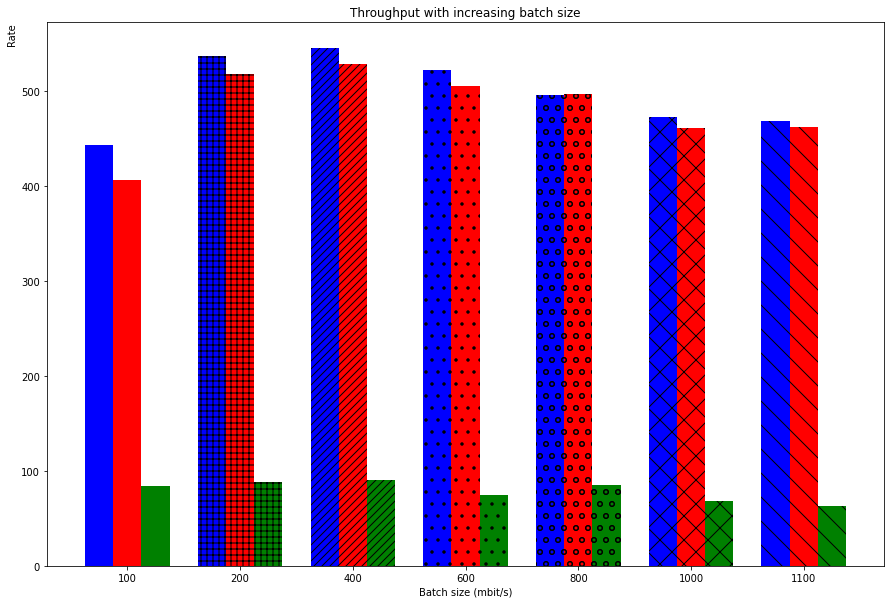

In [85]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
    p = s3_both[(s3_both["pf"]==2) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)

    p = s3_both[(s3_both["pf"]==4) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("Batch size (mbit/s)", loc="center")
ax.set_xticklabels([0]+batch_sizes, fontdict=None)
ax.set_ylabel("Rate", loc="top")
ax.set_title(f"Throughput with increasing batch size", loc='center')

/tmp/ipykernel_150027/4074255580.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


Text(0.5, 1.0, 'GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla')

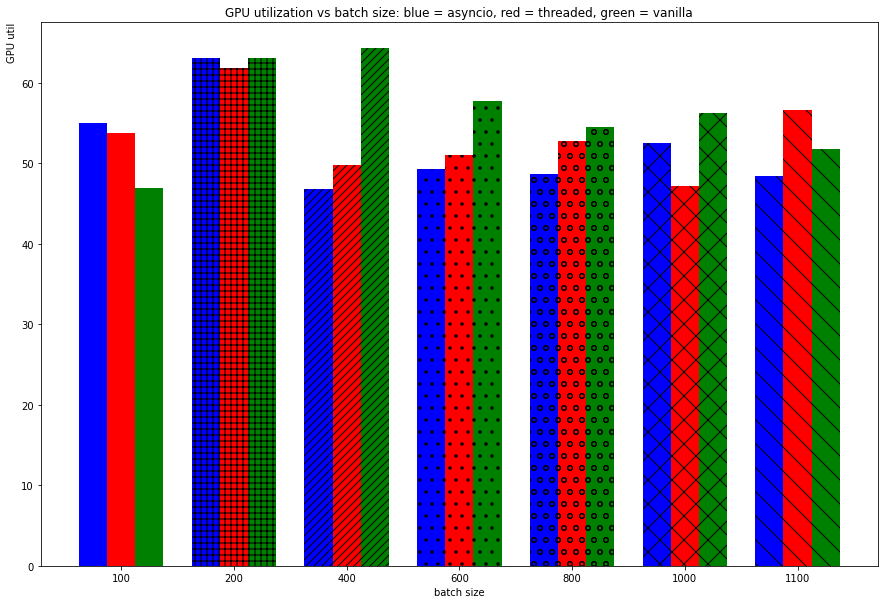

In [365]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
    p = s3_both[(s3_both["pf"]==2) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

    p = s3_both[(s3_both["pf"]==4) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("batch size", loc="center")
ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
ax.set_ylabel("GPU util", loc="top")
ax.set_title(f"GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla", loc='center')


120000
Lines num: 120026


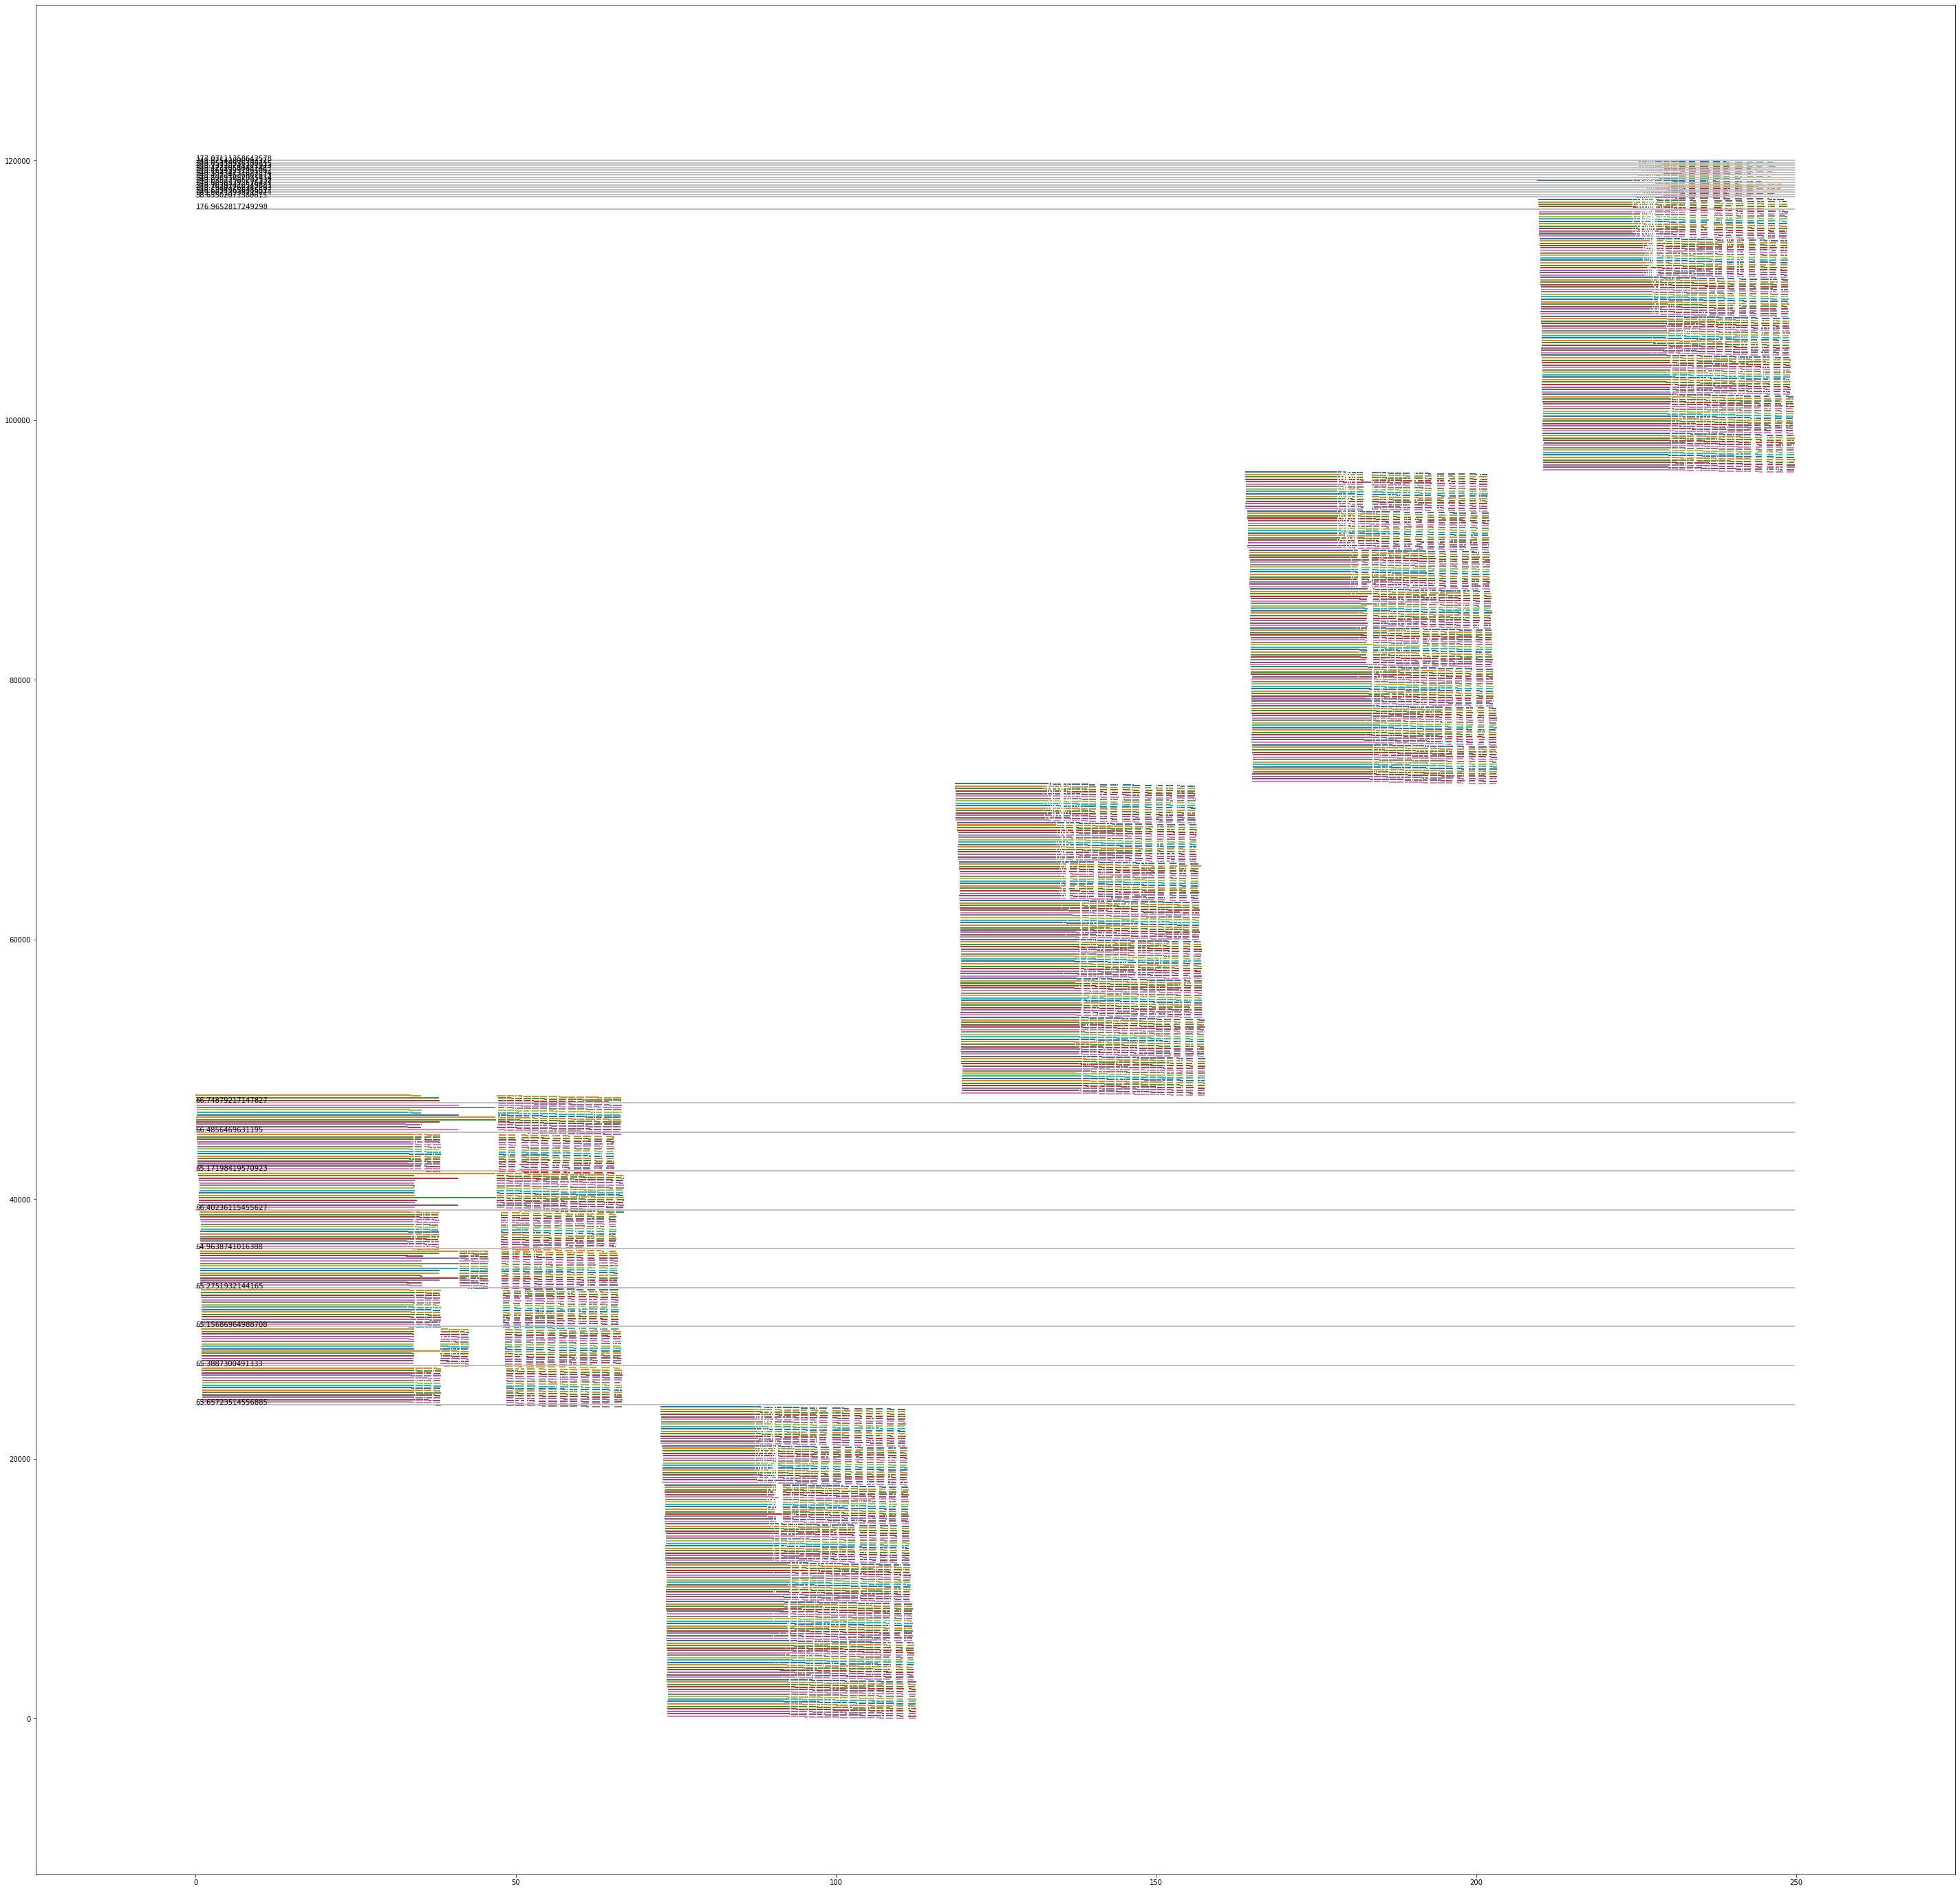

In [95]:
run = df_dataloader_async[(df_dataloader_async["num_workers"]==8) & 
                          (df_dataloader_async["batch_size"]==100)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_async[df_dataloader_async["run"]==run], 
                              filter_function="__getitem__")


120000
Lines num: 120115


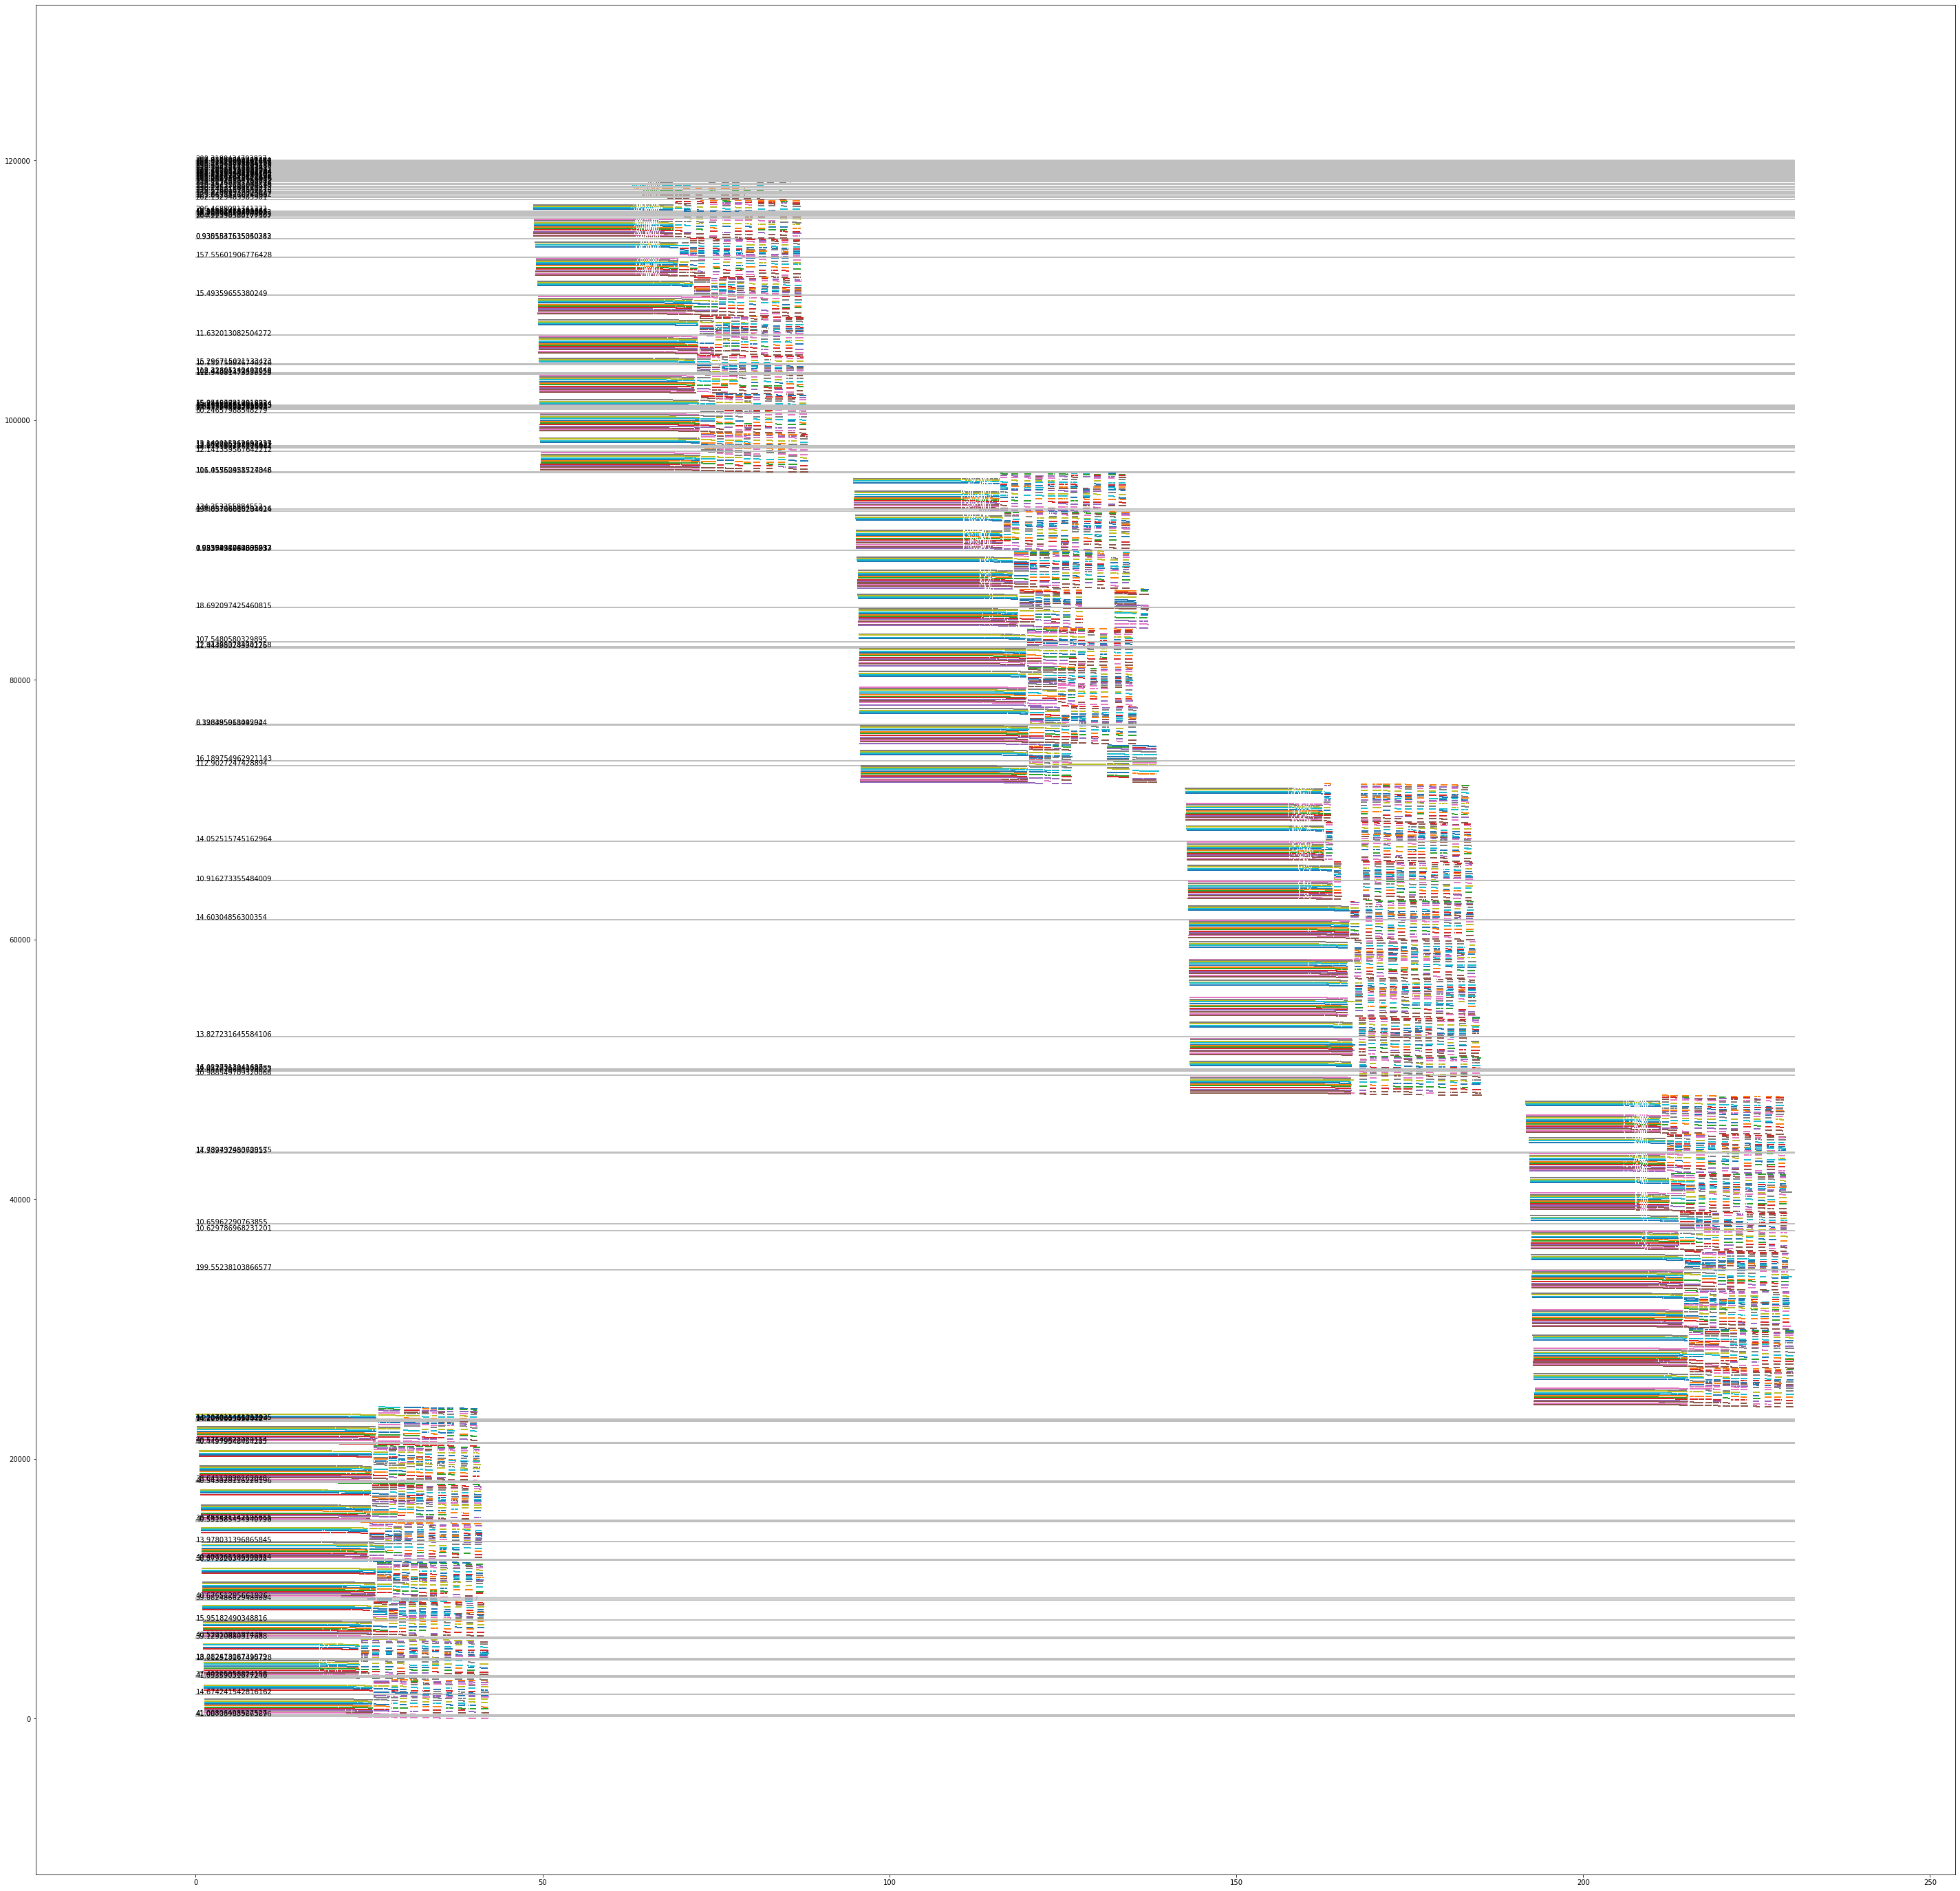

In [97]:
run = df_dataloader_threaded[(df_dataloader_threaded["num_workers"]==8) & 
                             (df_dataloader_threaded["batch_size"]==100)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="__getitem__")


120000
Lines num: 120001


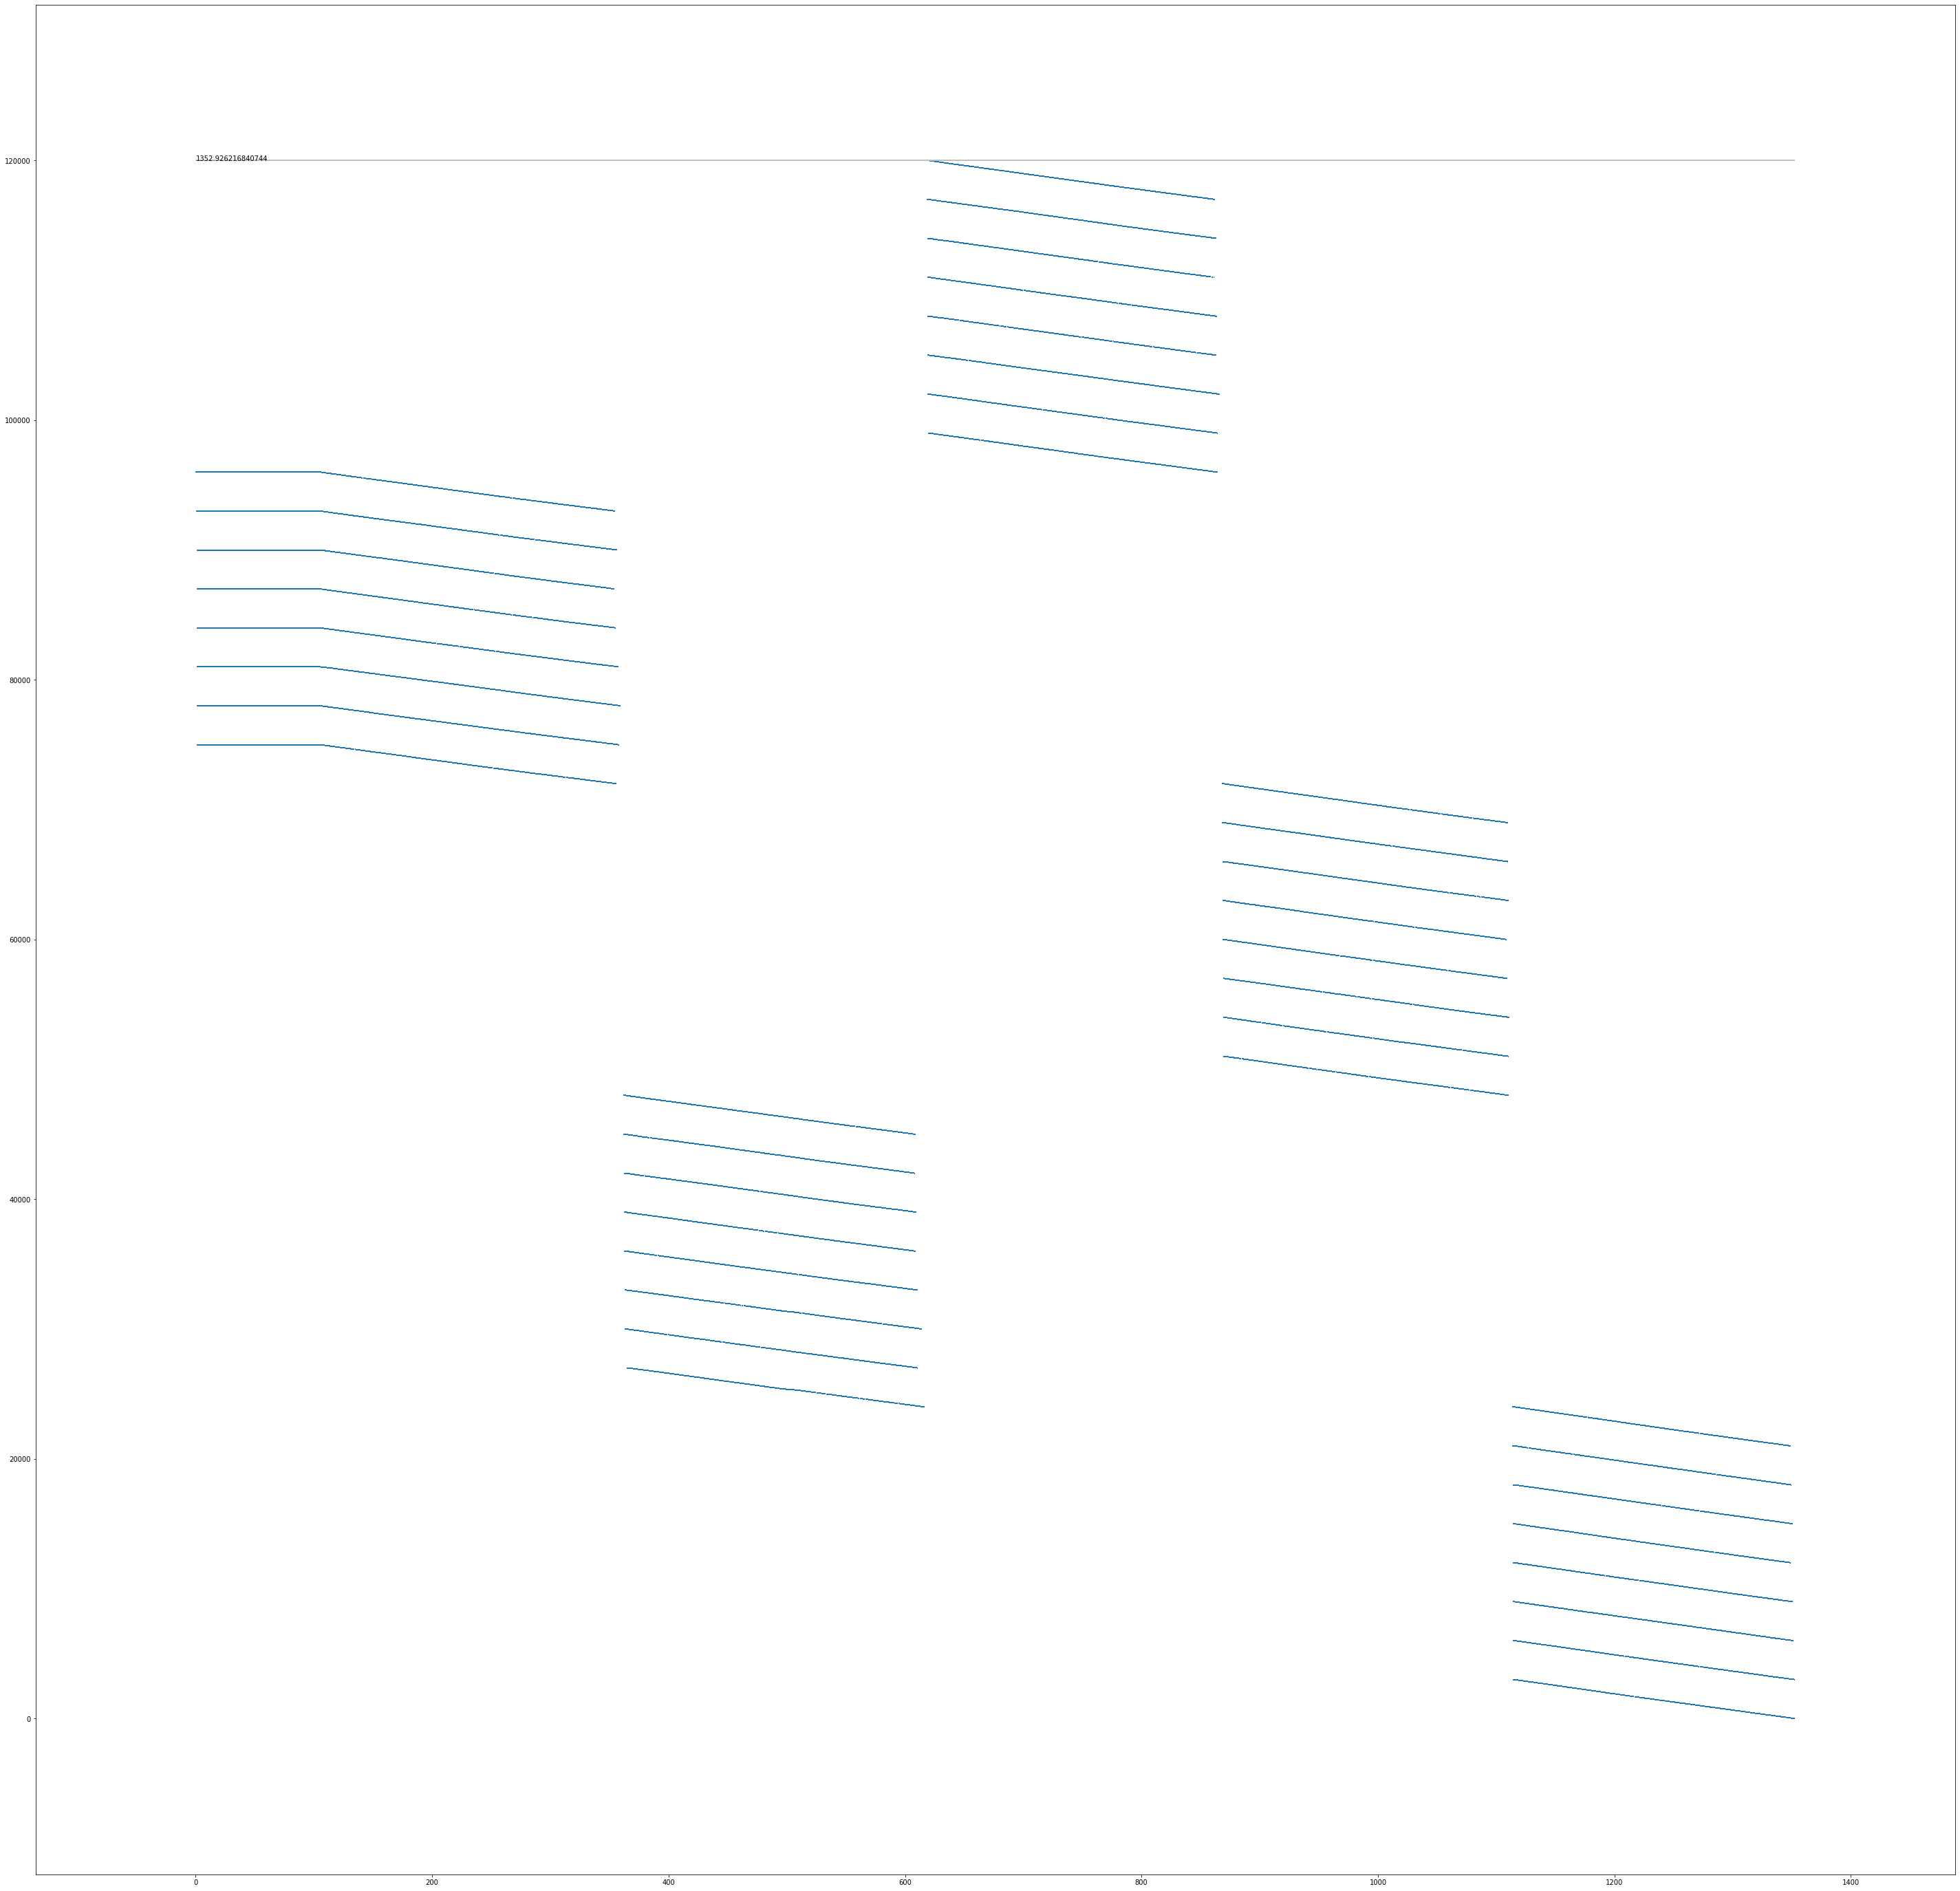

In [96]:
run = df_dataloader_vanilla[(df_dataloader_vanilla["num_workers"]==8) & 
                             (df_dataloader_vanilla["batch_size"]==100)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run], 
                              filter_function="__getitem__")


### RATE

In [112]:
s3_both

batch_size num_fetch_workers num_workers  a_rate      a_gpu   pf  t_rate  \
0        100              [16]         [8]   443.0  55.045833  4.0   406.4   
1        200              [16]         [8]   536.6  63.016667  4.0   517.6   
2        400              [16]         [8]   545.0  46.850000  4.0   528.5   
3        600              [16]         [8]   521.7  49.325000  4.0   505.2   
4        800              [16]         [8]   495.6  48.700000  4.0   496.7   
5       1000              [16]         [8]   472.0  52.541667  4.0   461.1   
6       1100              [16]         [8]   467.9  48.409091  4.0   461.8   

       t_gpu  v_rate      v_gpu  
0  53.700000    84.5  46.870833  
1  61.858333    88.6  63.083333  
2  49.750000    90.2  64.300000  
3  51.050000    74.8  57.750000  
4  52.733333    85.1  54.500000  
5  47.125000    67.8  56.208333  
6  56.590909    62.5  51.772727

In [366]:
def plot_stats(d1):   
    fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for i, (batch_size, color) in enumerate(zip(batch_sizes, 
                                                ["red", "gray", "lime", "aqua", "yellow", "green", "gold"])):
        current_batch = d1[d1["batch_size"]==batch_size]
        current_batch = current_batch.sort_values(["batch_size"], ascending=True)
        xrange = 0
        ax.bar(x=i+xrange, height=current_batch["a_rate"], width=0.25, color=color, label=f"A-rate, {batch_size}")
        ax.bar(x=i+xrange+0.3, height=current_batch["t_rate"], hatch="xxx", color=color, width=0.25, label=f"T-Rate, {batch_size}")
        ax.bar(x=i+xrange+0.6, height=current_batch["v_rate"], hatch="...", color=color, width=0.25, label=f"V-Rate, {batch_size}")
        
    ax.grid(linestyle='--', which="both")
    ax.set_xticklabels([0] + batch_sizes, fontdict=None)

    del current_batch
    ax.set_xlabel(f"batch size", loc="center")
    ax.set_ylabel("Rate", loc="top")
    ax.set_title(f"S3 Asyncio vs. Threaded vs. Vanilla Pytorch + Batch sizes", loc='center')
    ax.legend()


/tmp/ipykernel_150027/911586854.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + batch_sizes, fontdict=None)


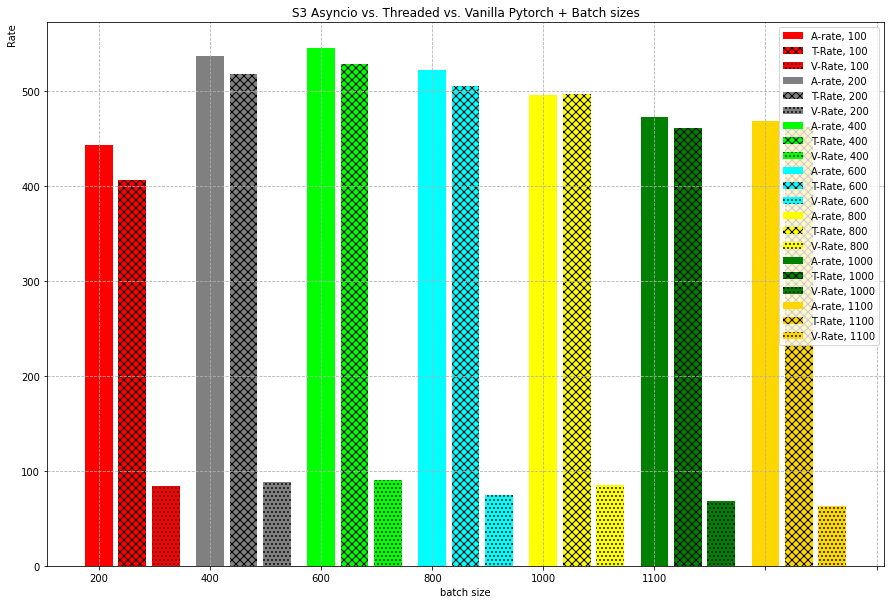

In [367]:
plot_stats(s3_both)

!!! **Vannila is good with many workers and small batches!**

In [34]:
#f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]=="__getitem__"]
#f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]=="__getitem__"]
#f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]=="__getitem__"]

In [186]:
print(np.unique(df_dataloader_s3_async["function_name"].to_numpy()))

['__getitem__' '_worker_loop' 'advance' 'batch_to_device' 'fetch'
 'start_train']


In [187]:
df_dataloader_s3_async["prefetch_factor"]

0         4
1         4
2         4
3         4
4         4
         ..
845922    4
845923    4
845924    4
845925    4
845926    4
Name: prefetch_factor, Length: 845927, dtype: int64

In [188]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [443]:
# fn = "__getitem__"
def plot_stats(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for bs in batch_sizes:
        skip_time = 10
        f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]==fn]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]==fn]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]==fn]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
    
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(f_df_dataloader_s3_async)), f_df_dataloader_s3_async["elapsed"],color="red",label="async")
        ax.plot(range(len(f_df_dataloader_s3_threaded)), f_df_dataloader_s3_threaded["elapsed"],color="blue",label="threaded")
        ax.plot(range(len(f_df_dataloader_s3_vanilla)), f_df_dataloader_s3_vanilla["elapsed"],color="green",label="vanilla")
    
        
        if show_mean:
            ax.axhline(y=f_df_dataloader_s3_async["elapsed"].mean(),color="red", linestyle="--",label="async mean")
            ax.axhline(y=f_df_dataloader_s3_threaded["elapsed"].mean(),color="blue", linestyle="--",label="threaded mean")
            ax.axhline(y=f_df_dataloader_s3_vanilla["elapsed"].mean(),color="green", linestyle="--",label="vanilla mean")
        
        del f_df_dataloader_s3_vanilla
        del f_df_dataloader_s3_threaded
        del f_df_dataloader_s3_async
        ax.set_xlabel(f"Experiment", loc="center")
        ax.set_ylabel("Duration (s)", loc="top")
        ax.set_title(f"{fn}, {bs}", loc='center')
        ax.legend()

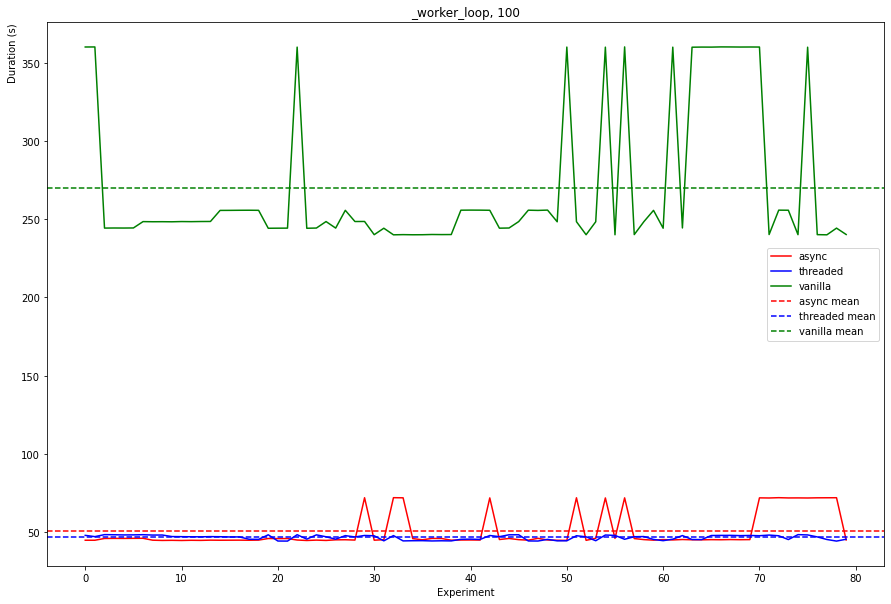

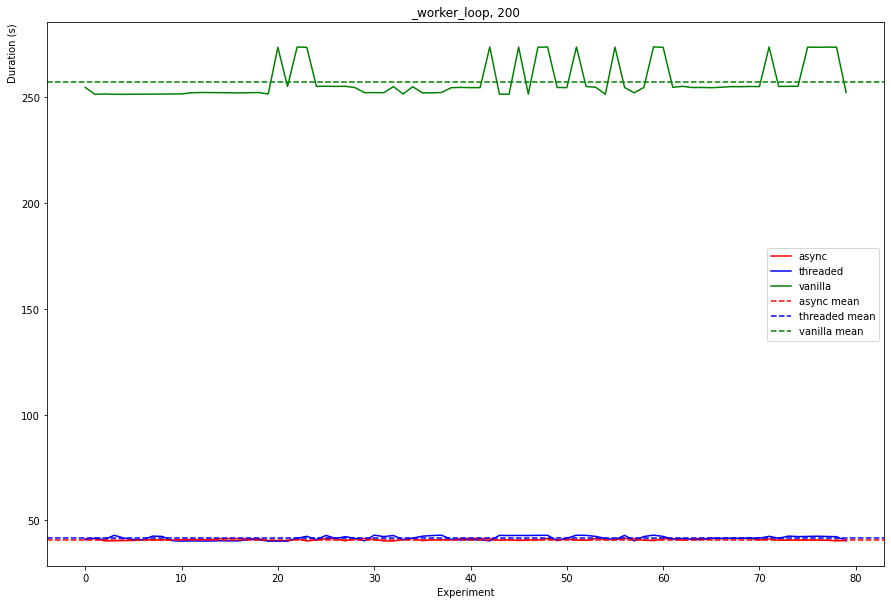

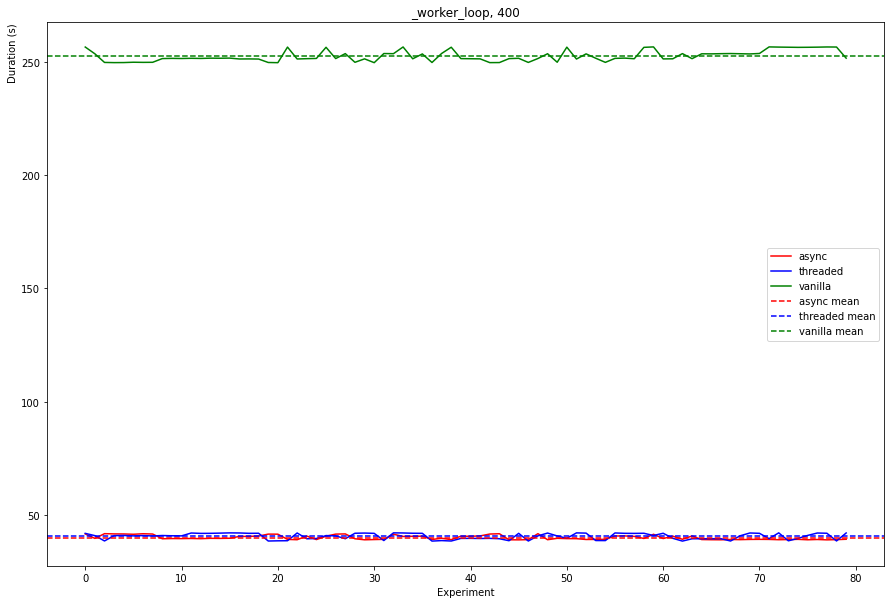

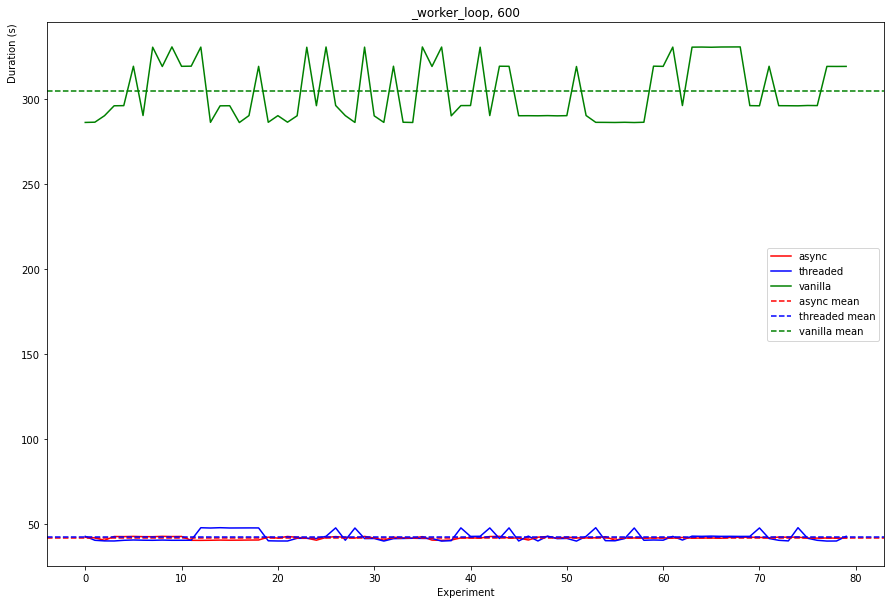

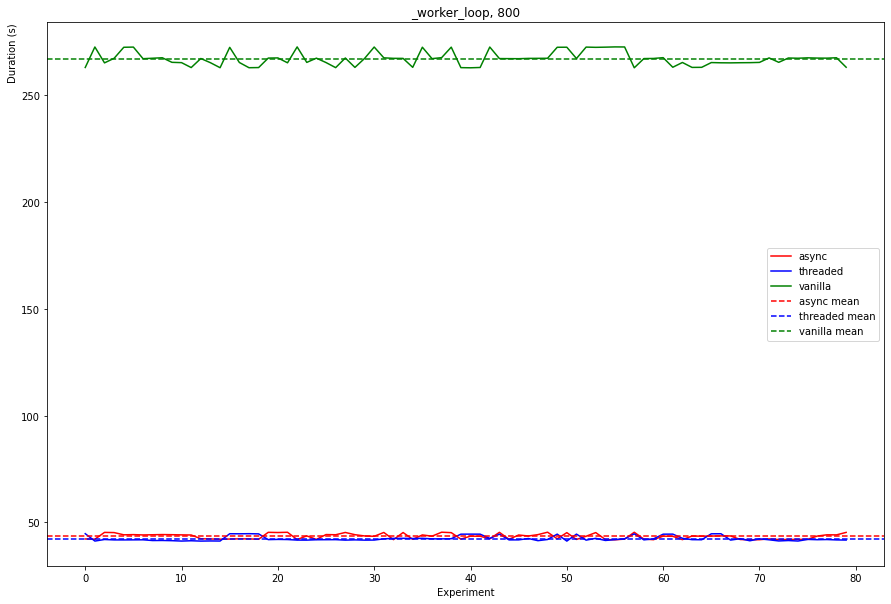

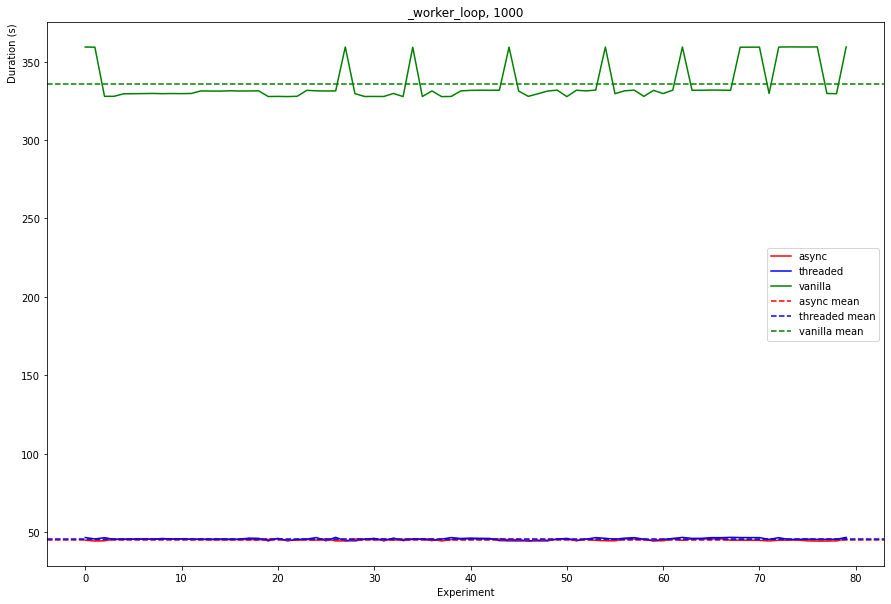

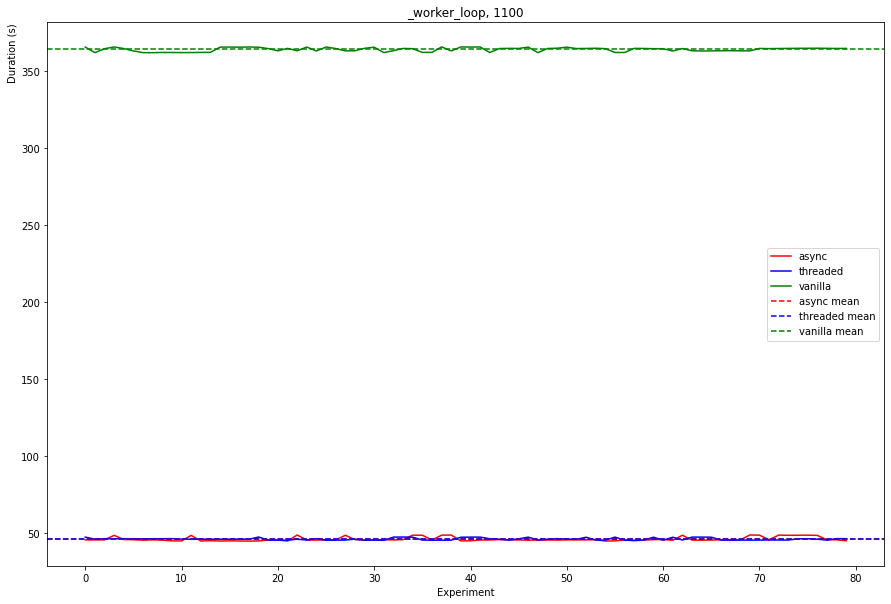

In [440]:
plot_stats("_worker_loop", True)

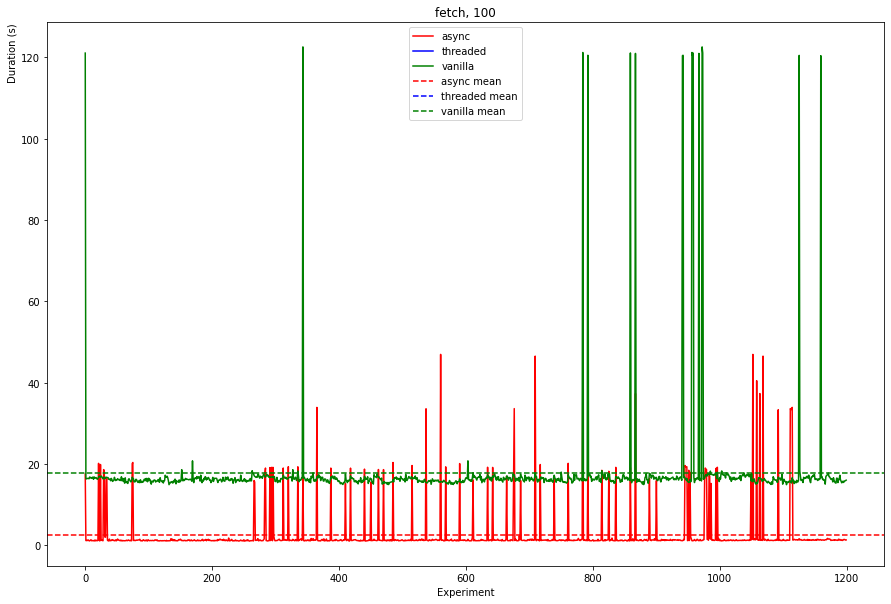

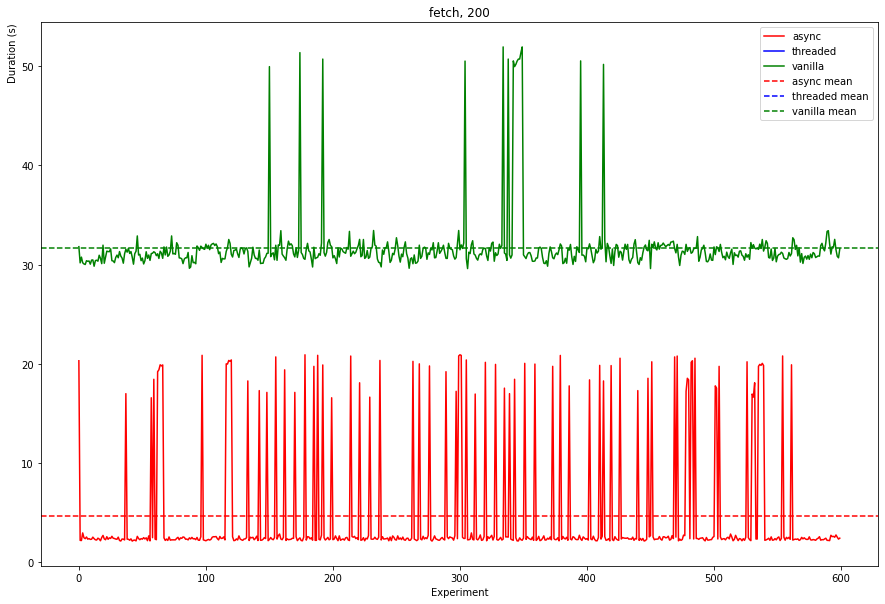

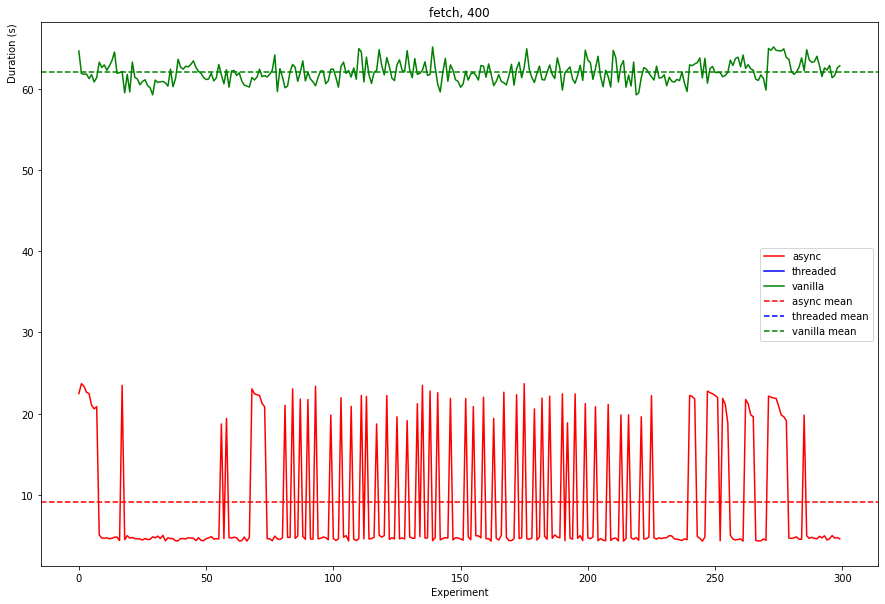

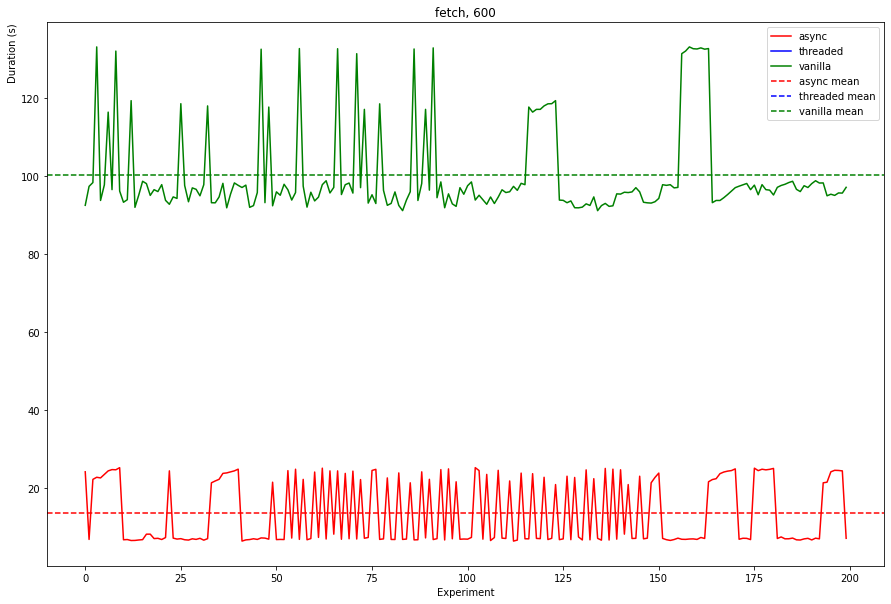

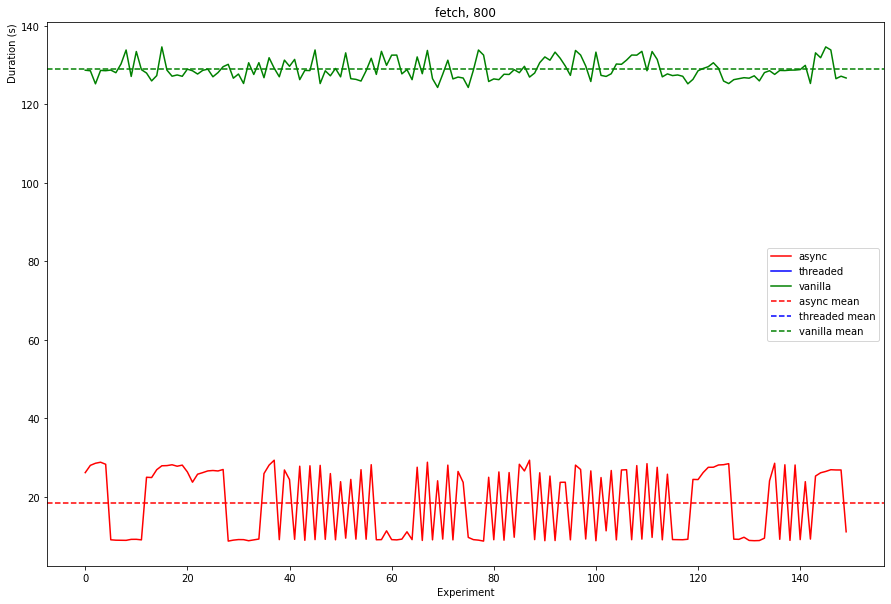

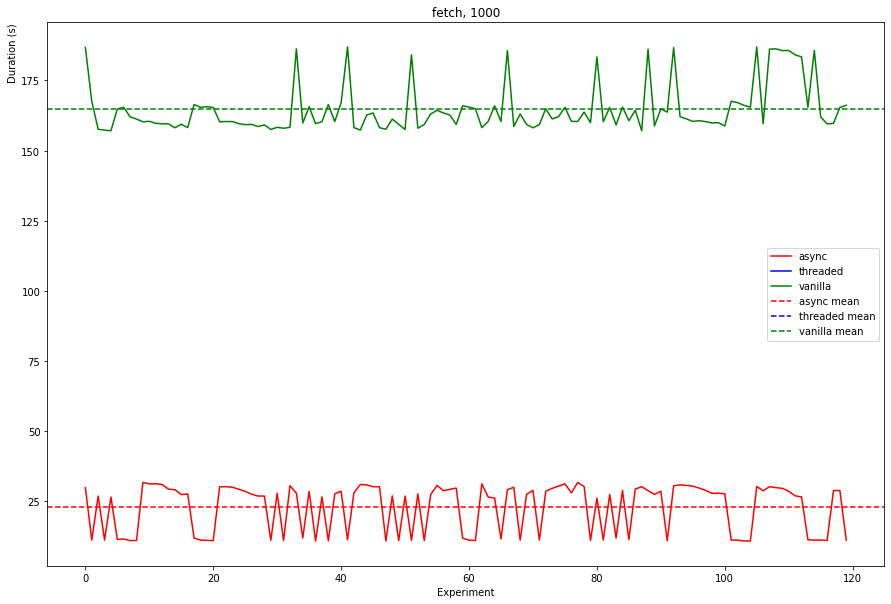

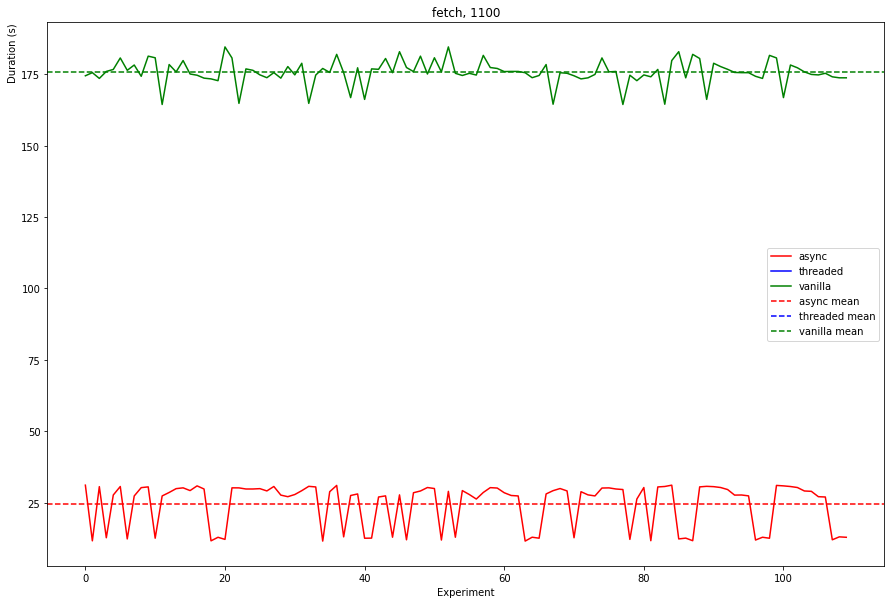

In [441]:
plot_stats("fetch", True)

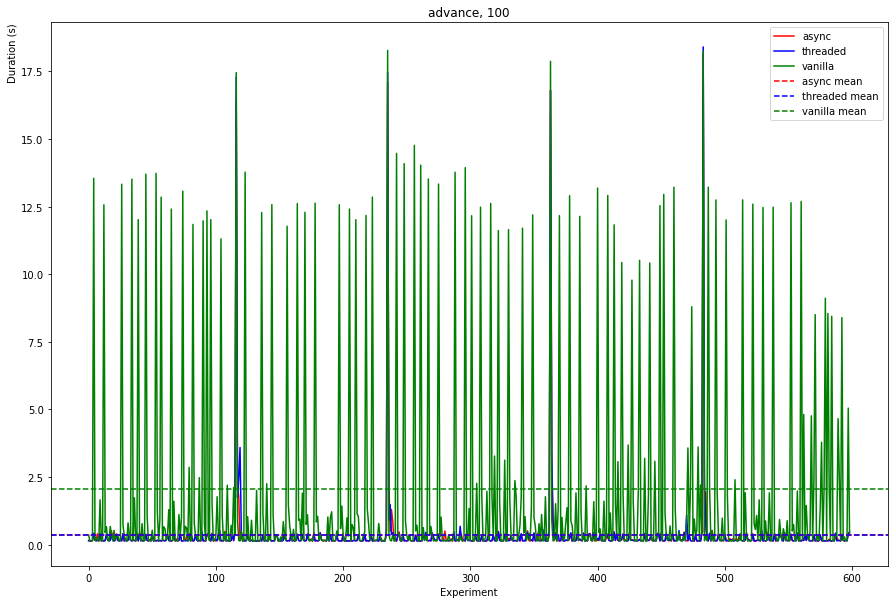

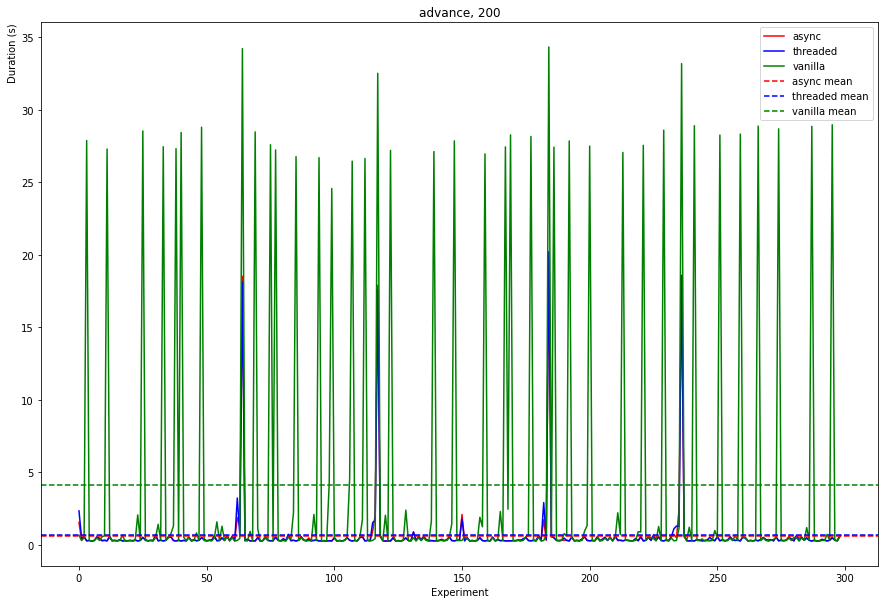

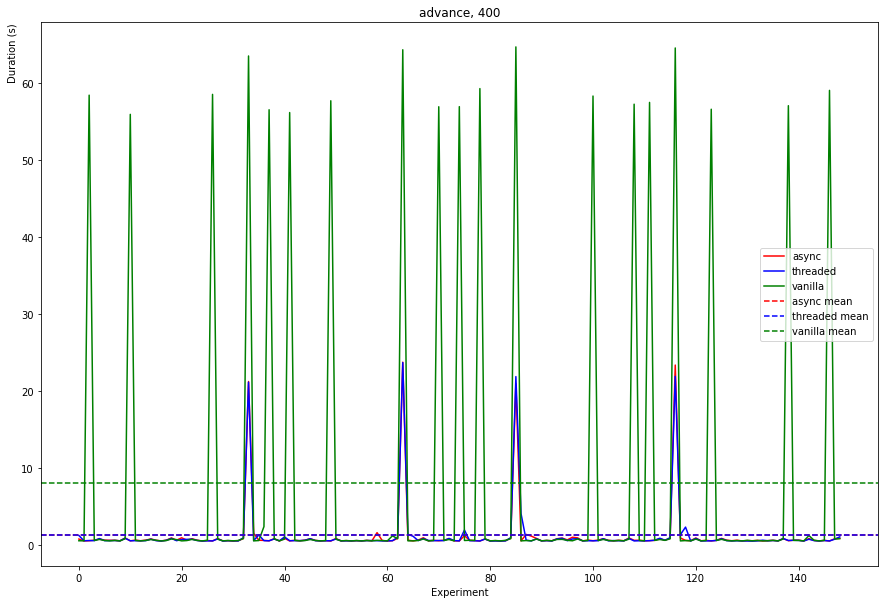

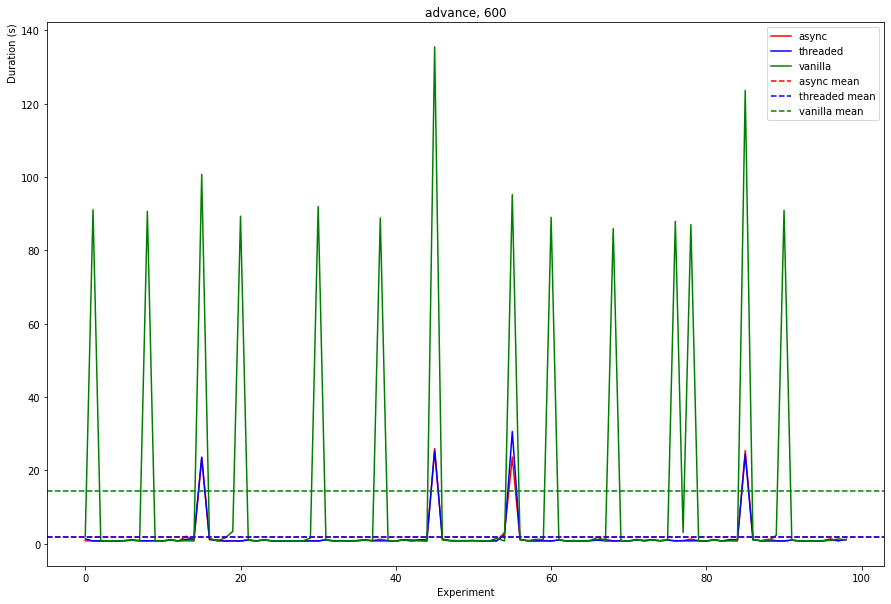

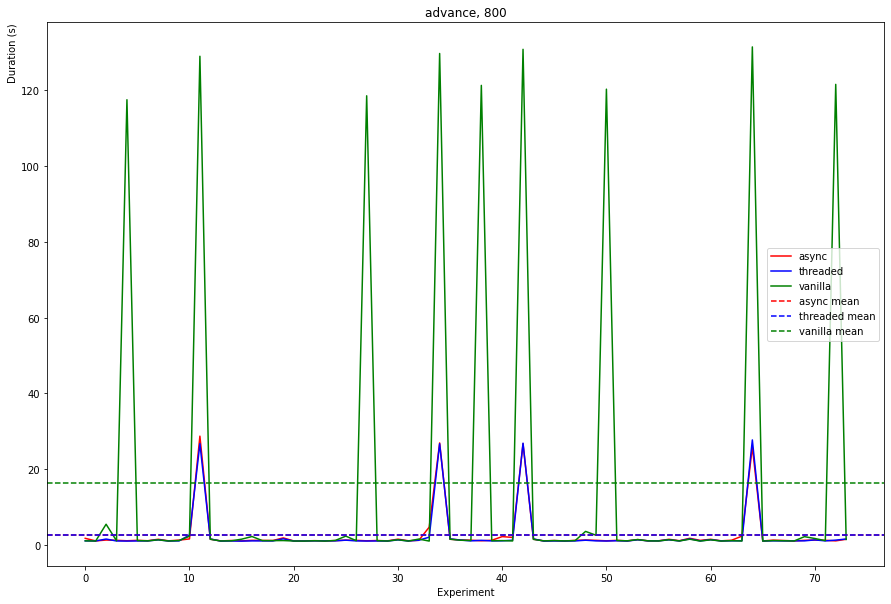

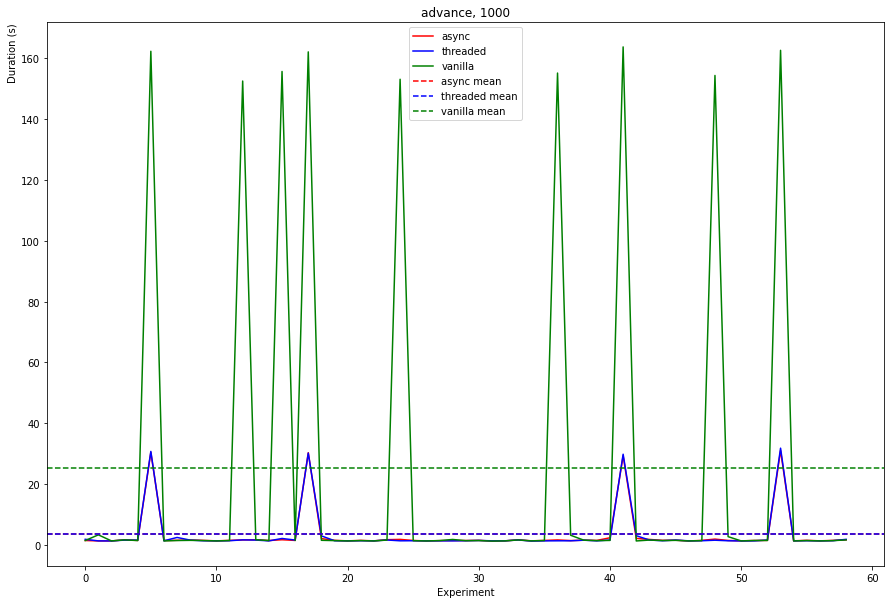

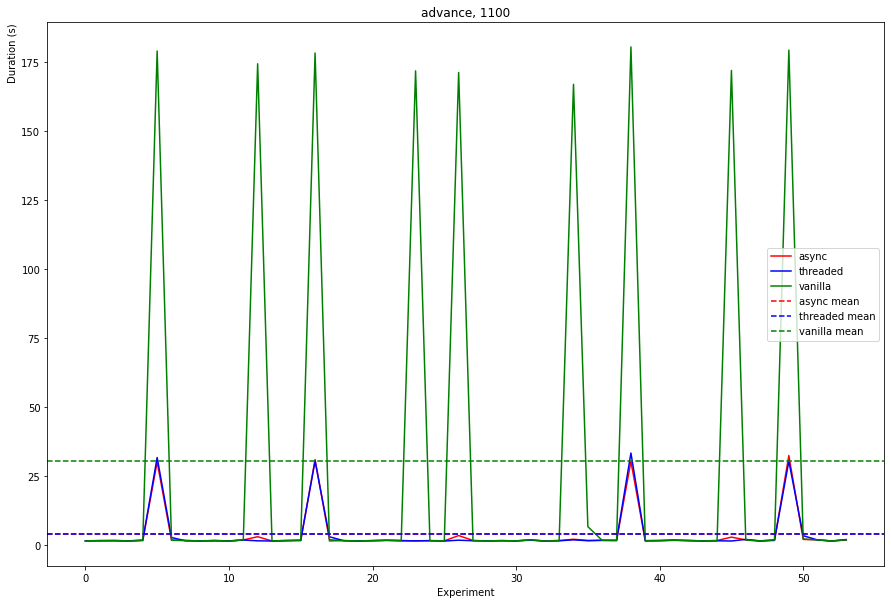

In [444]:
plot_stats("advance", True)

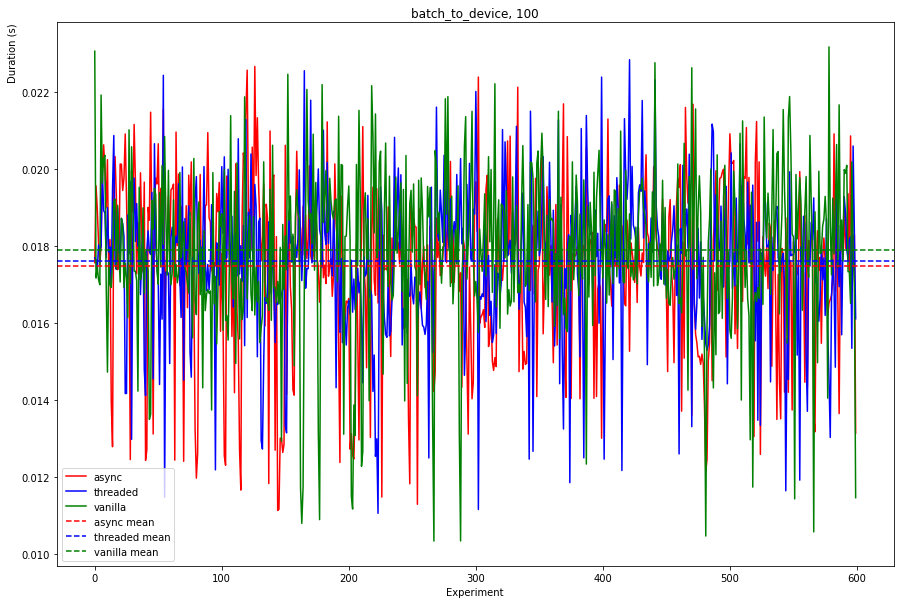

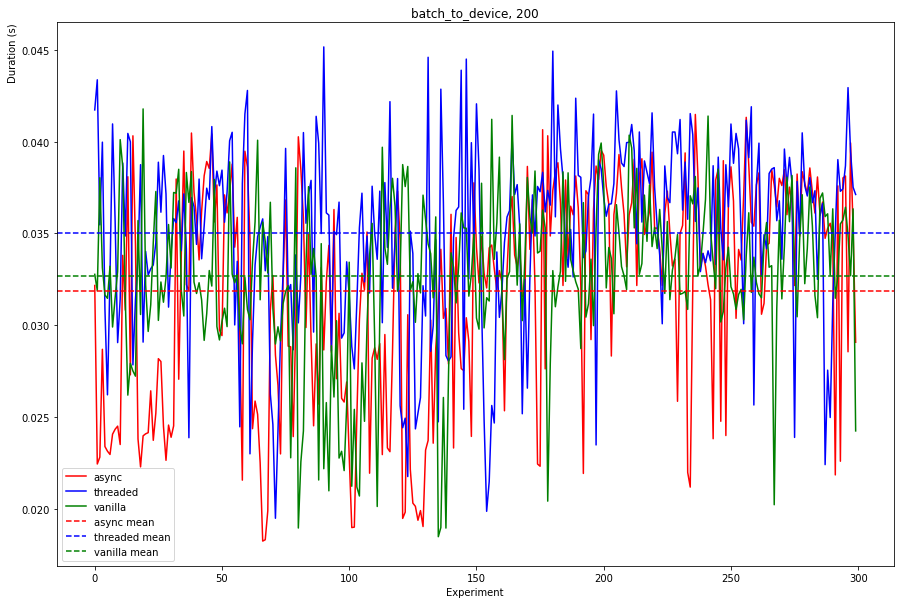

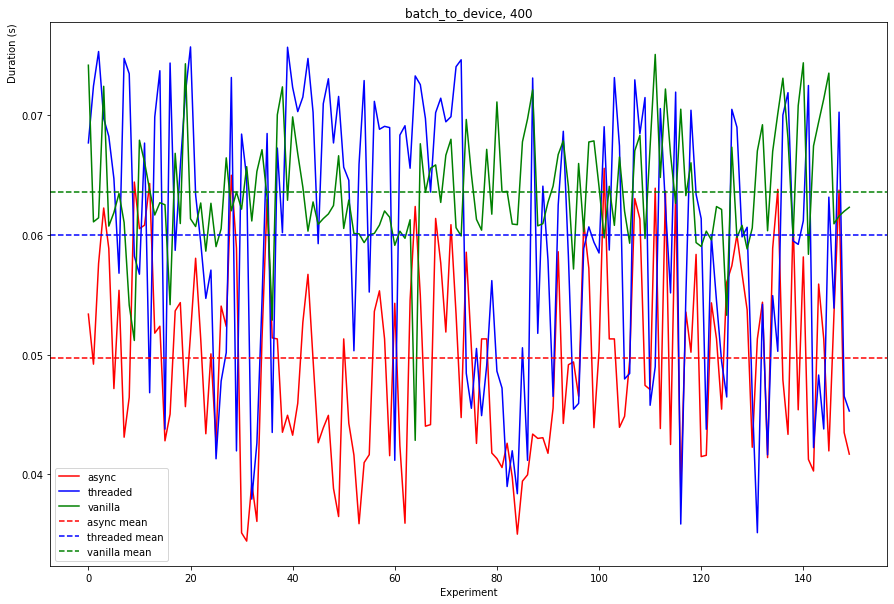

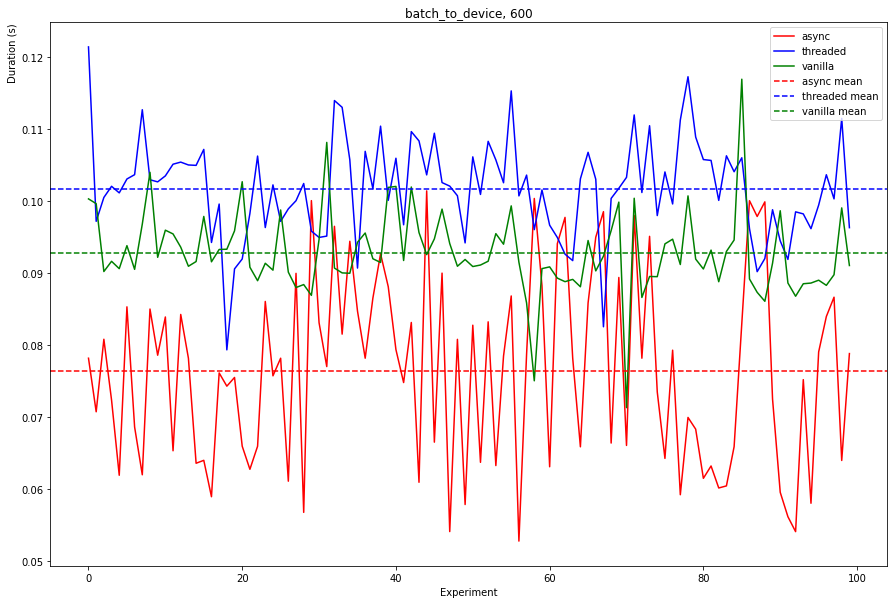

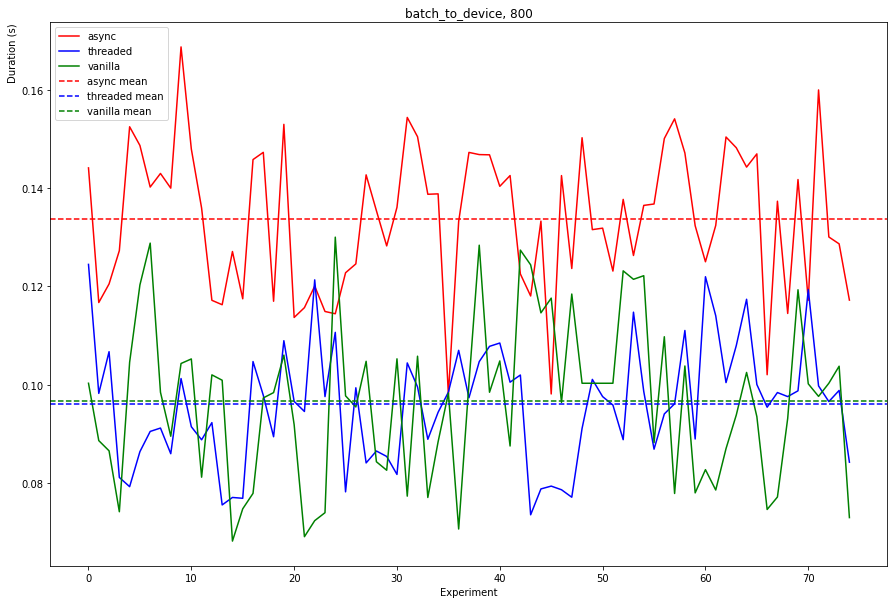

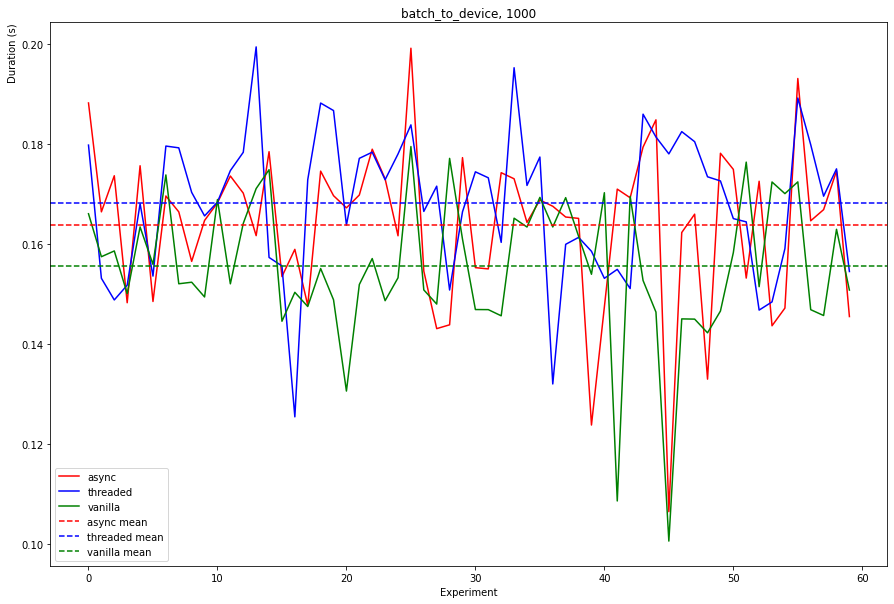

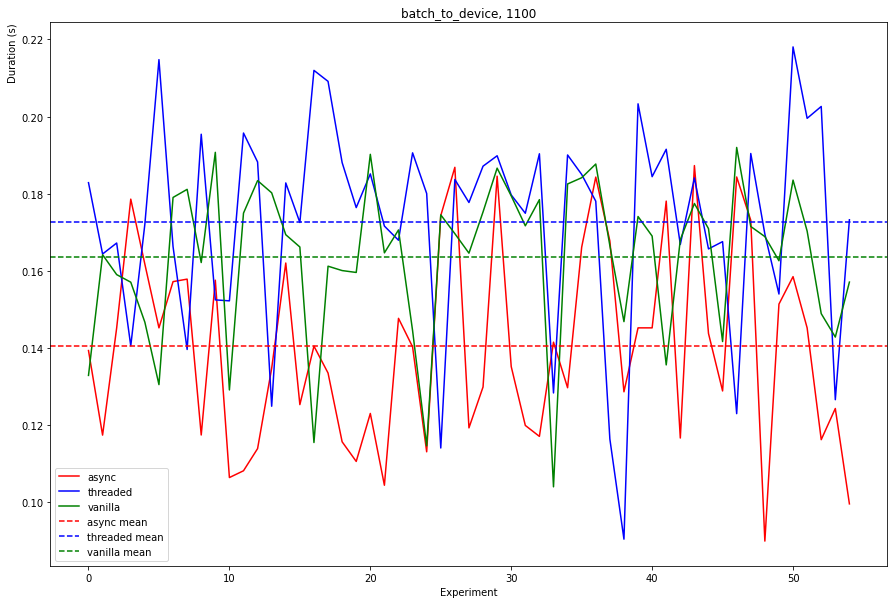

In [432]:
plot_stats("batch_to_device", True)

### GPU Utilization

In [290]:
def plot_gpu_stats(d1):   
#     ax.axis(ymin=0.003, ymax=0.012)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i, (batch_size, color) in enumerate(zip(batch_sizes, 
                                                ["red", "gray", "lime", "aqua", "yellow", "green", "gold"])):
        s3_fix_1 = d1[d1["batch_size"]==batch_size]
        ax.bar(x=i, height=s3_fix_1["a_gpu"], width=0.25, color=color, label=f"A-util, {batch_size}")
        ax.bar(x=i+0.3, height=s3_fix_1["t_gpu"], hatch="xxx", color=color, width=0.25, label=f"T-util, {batch_size}")
        ax.bar(x=i+0.6, height=s3_fix_1["v_gpu"], hatch="...", color=color, width=0.25, label=f"V-util, {batch_size}")

    ax.grid(linestyle='--', which="both")
    ax.set_xlabel(f"Batch sizes", loc="center")
    ax.set_ylabel("GPU Util", loc="top")
    ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
    ax.set_title(f"", loc='center')

/tmp/ipykernel_150027/1691066276.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


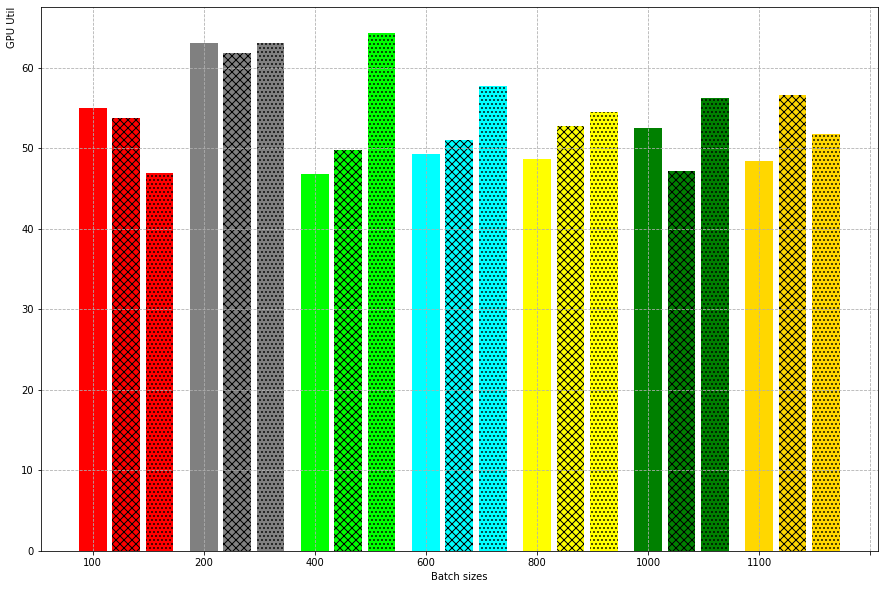

In [291]:
plot_gpu_stats(s3_both)

### Batch download - sum

In [292]:
df_s3_gpu_util

run  \
0    20211017f123933_benchmark_e2e_s3_800_8_16_sync   
1    20211017f114609_benchmark_e2e_s3_400_8_16_sync   
2   20211017f152819_benchmark_e2e_s3_1100_8_16_sync   
3    20211017f151622_benchmark_e2e_s3_600_8_16_sync   
4   20211017f152408_benchmark_e2e_s3_1000_8_16_sync   
5    20211017f143719_benchmark_e2e_s3_800_8_16_sync   
6    20211017f143325_benchmark_e2e_s3_600_8_16_sync   
7    20211017f142152_benchmark_e2e_s3_100_8_16_sync   
8    20211017f150903_benchmark_e2e_s3_200_8_16_sync   
9    20211017f105437_benchmark_e2e_s3_100_8_16_sync   
10   20211017f150437_benchmark_e2e_s3_100_8_16_sync   
11   20211017f151244_benchmark_e2e_s3_400_8_16_sync   
12  20211017f144112_benchmark_e2e_s3_1000_8_16_sync   
13  20211017f130601_benchmark_e2e_s3_1000_8_16_sync   
14   20211017f142559_benchmark_e2e_s3_200_8_16_sync   
15  20211017f133521_benchmark_e2e_s3_1100_8_16_sync   
16  20211017f144521_benchmark_e2e_s3_1100_8_16_sync   
17   20211017f152009_benchmark_e2e_s3_800_8_16_sync   
18   20211017f121034_benchmark_e2e_s3_600_8_16_sync   
19   20211017f142943_benchmark_e2e_s3_400_8_16_sync   
20   20211017f112109_benchmark_e2e_s3_200_8_16_sync   

                                                  gpu   gpu_mean  gpu_median  \
0   [12.0, 69.0, 24.0, 93.0, 24.0, 82.0, 24.0, 86....  54.500000        41.5   
1   [55.0, 58.0, 45.0, 100.0, 66.0, 60.0, 42.0, 97...  64.300000        67.5   
2   [18.0, 67.0, 43.0, 49.0, 14.0, 84.0, 26.0, 100...  48.409091        44.0   
3   [12.0, 100.0, 18.0, 47.0, 18.0, 44.0, 18.0, 71...  49.325000        40.5   
4   [27.0, 53.0, 42.0, 70.0, 12.0, 100.0, 23.0, 82...  52.541667        47.5   
5   [43.0, 46.0, 56.0, 100.0, 24.0, 86.0, 24.0, 86...  52.733333        45.5   
6   [17.0, 34.0, 32.0, 72.0, 58.0, 89.0, 18.0, 59....  51.050000        43.5   
7   [71.0, 60.0, 28.0, 60.0, 56.0, 17.0, 75.0, 40....  53.700000        58.0   
8   [53.0, 100.0, 93.0, 39.0, 67.0, 100.0, 55.0, 8...  63.016667        67.0   
9   [0.0, 67.0, 0.0, 55.0, 34.0, 70.0, 78.0, 36.0,...  46.870833        54.5   
10  [31.0, 70.0, 36.0, 70.0, 20.0, 70.0, 75.0, 49....  55.045833        59.0   
11  [12.0, 37.0, 12.0, 90.0, 4.0, 78.0, 72.0, 76.0...  46.850000        48.0   
12  [14.0, 100.0, 17.0, 100.0, 7.0, 100.0, 42.0, 8...  47.125000        40.0   
13  [24.0, 66.0, 18.0, 100.0, 30.0, 100.0, 29.0, 8...  56.208333        58.0   
14  [44.0, 97.0, 38.0, 100.0, 91.0, 25.0, 47.0, 84...  61.858333        66.5   
15  [28.0, 100.0, 31.0, 100.0, 36.0, 100.0, 14.0, ...  51.772727        34.5   
16  [29.0, 100.0, 33.0, 100.0, 22.0, 100.0, 17.0, ...  56.590909        44.0   
17  [14.0, 62.0, 38.0, 100.0, 14.0, 100.0, 8.0, 48...  48.700000        47.5   
18  [18.0, 61.0, 18.0, 100.0, 18.0, 100.0, 14.0, 1...  57.750000        61.0   
19  [10.0, 78.0, 56.0, 54.0, 31.0, 38.0, 12.0, 77....  49.750000        48.0   
20  [66.0, 93.0, 6.0, 84.0, 19.0, 86.0, 63.0, 71.0...  63.083333        71.0   

          std  
0   33.812966  
1   31.223015  
2   29.575265  
3   33.889075  
4   29.538082  
5   31.392073  
6   29.431233  
7   19.986912  
8   32.011452  
9   26.314049  
10  20.263729  
11  28.494342  
12  29.193767  
13  31.037584  
14  31.792110  
15  30.623716  
16  34.094333  
17  31.600791  
18  35.329697  
19  31.846311  
20  33.236422

In [304]:
type(df_s3_gpu_util)

pandas.core.frame.DataFrame

In [620]:
# fn = "__getitem__"
def plot_stats2(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)

    for bs in batch_sizes:
        all_async = []
        all_threaded = []
        all_vanilla = []
        for index, row in df_s3_gpu_util.iterrows():
            skip_time = 10
            f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]==row["run"]]
            mean_async = f_df_dataloader_s3_async["elapsed"].mean()
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["elapsed"]<=mean_async*1.2]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
            all_async += list(f_df_dataloader_s3_async["elapsed"])
            del f_df_dataloader_s3_async
            
            f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["run"]==row["run"]]
            mean_threaded = f_df_dataloader_s3_threaded["elapsed"].mean()
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["elapsed"]<=mean_threaded*1.2]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["function_name"]==fn]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)
            all_threaded += list(f_df_dataloader_s3_threaded["elapsed"])
            del f_df_dataloader_s3_threaded
            
            f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["run"]==row["run"]]
            mean_vanilla = f_df_dataloader_s3_vanilla["elapsed"].mean()
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["elapsed"]<=mean_vanilla*1.2]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["function_name"]==fn]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
            all_vanilla += list(f_df_dataloader_s3_vanilla["elapsed"])
            del f_df_dataloader_s3_vanilla
        
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(all_async)), all_async, color="red",label="async")
        ax.plot(range(len(all_threaded)), all_threaded, color="blue",label="async")
        ax.plot(range(len(all_vanilla)), all_vanilla, color="green",label="async")
     
    del all_async
    del all_vanilla
    del mean_threaded
    ax.set_xlabel(f"Experiment", loc="center")
    ax.set_ylabel("Duration (s)", loc="top")
    ax.set_title(f"{fn}, {bs}", loc='center')
    ax.legend()

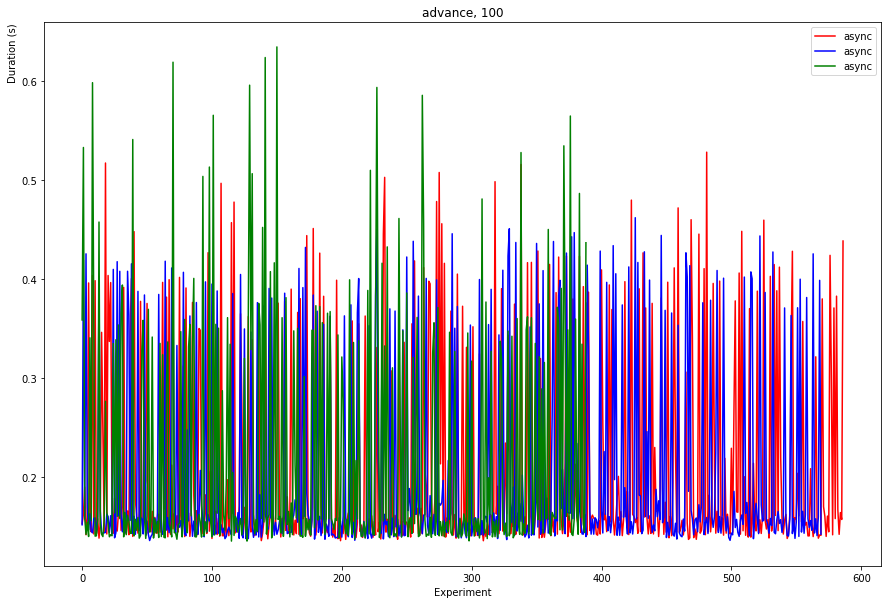

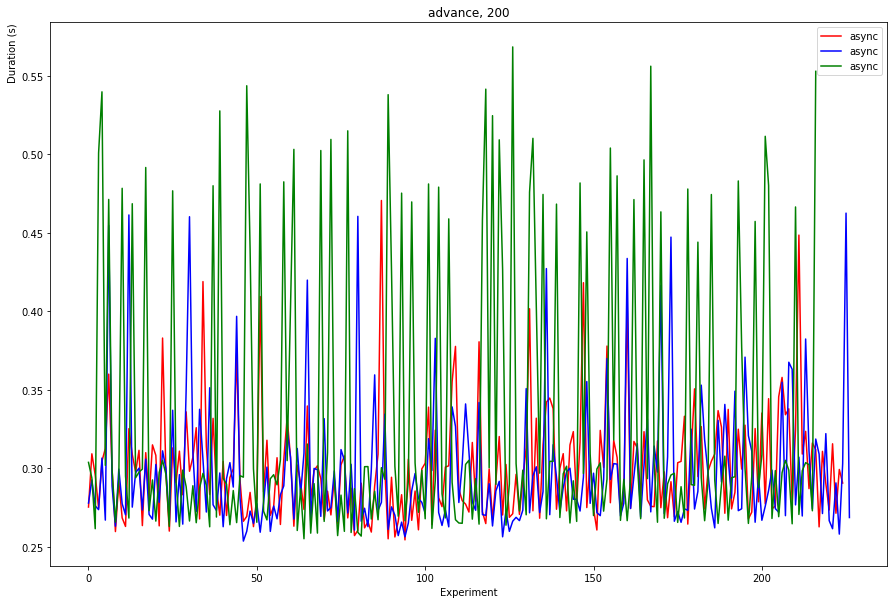

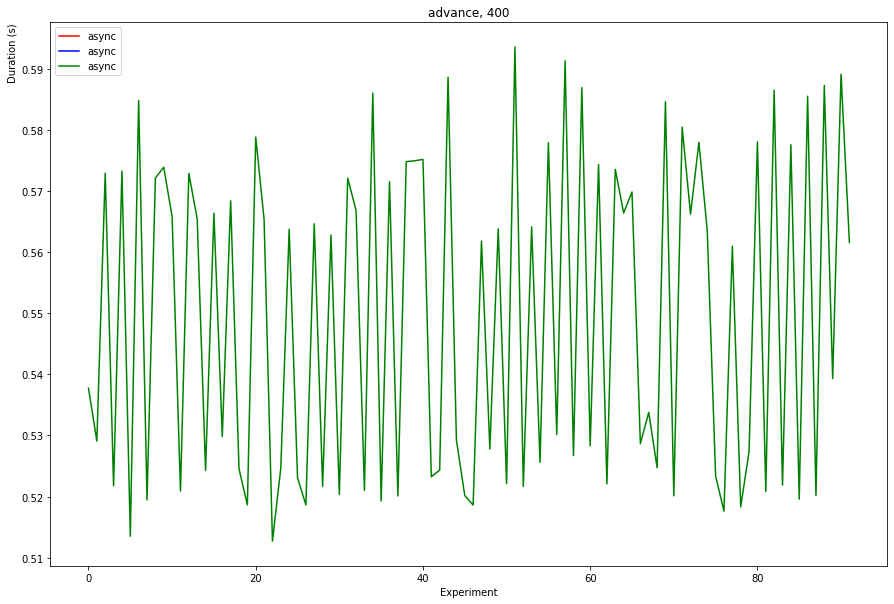

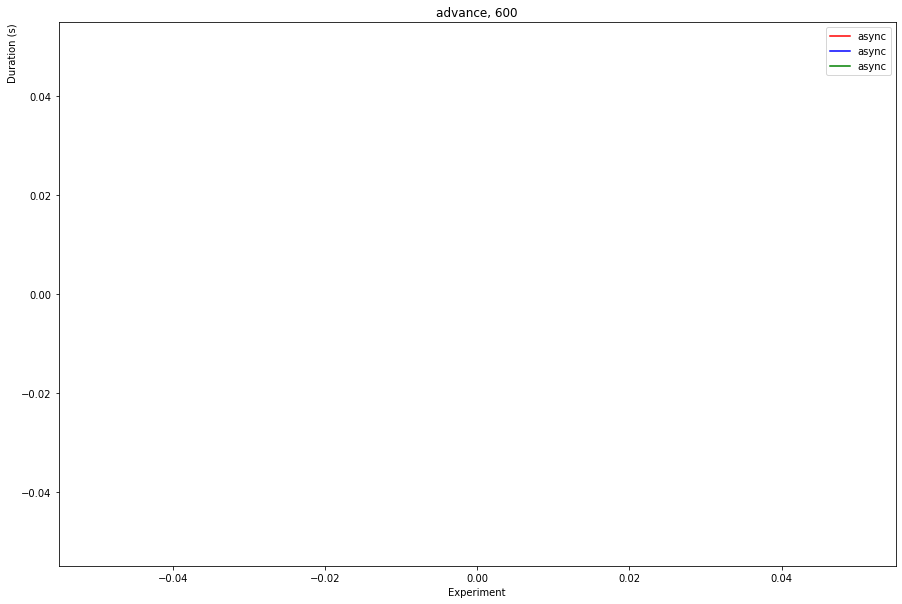

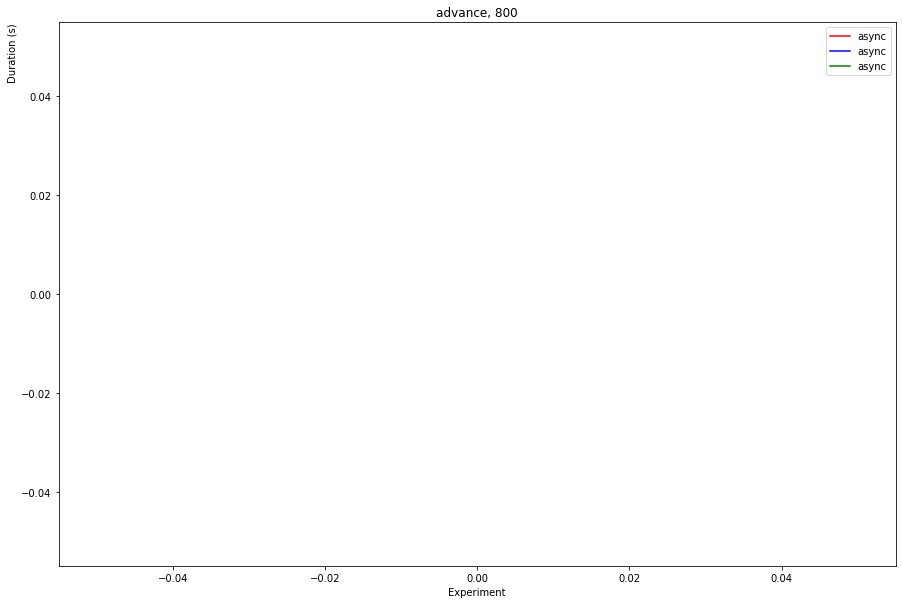

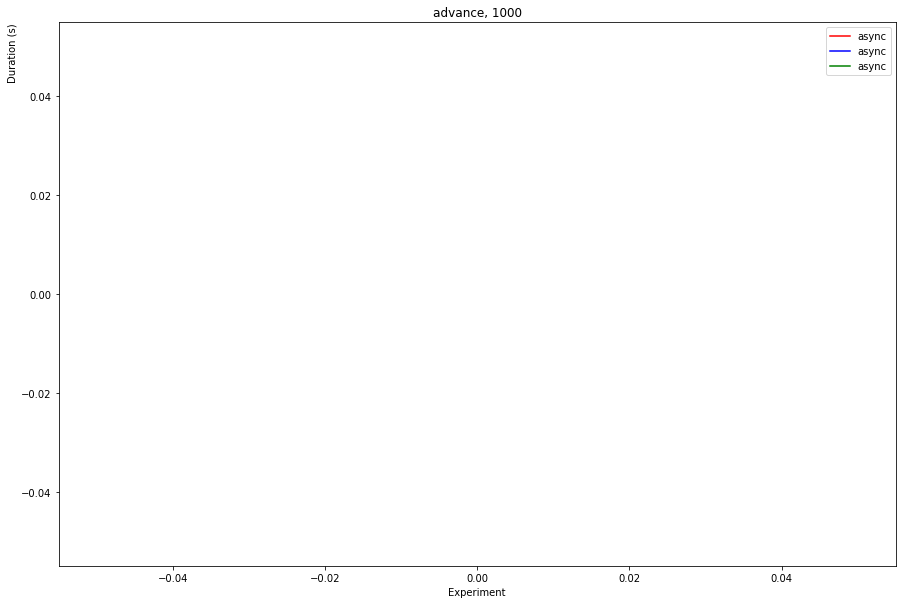

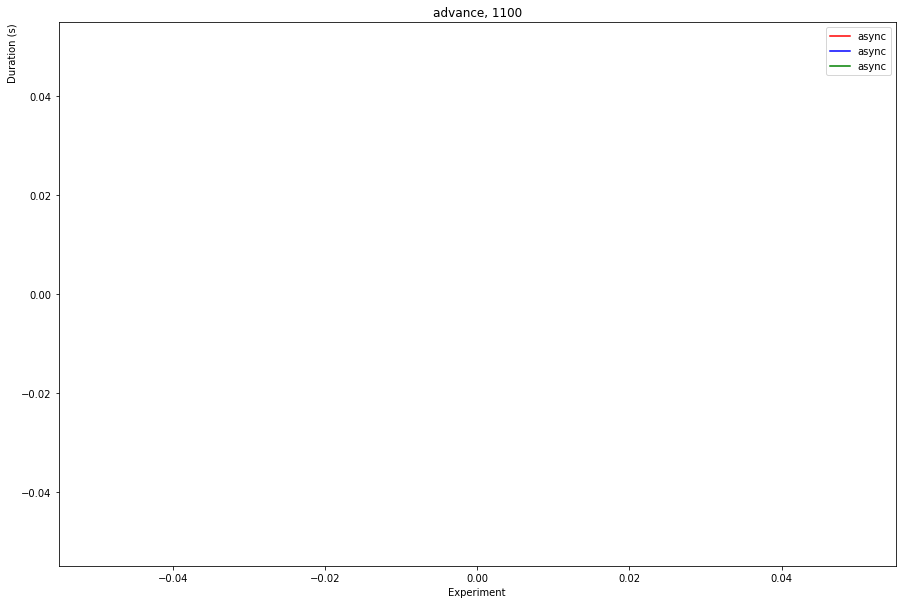

In [621]:
plot_stats2("advance", True)

IT is not only the experiment start, it is the EPOCH download start... 5 times, for each batch example

20211017f112109_benchmark_e2e_s3_200_8_16_sync


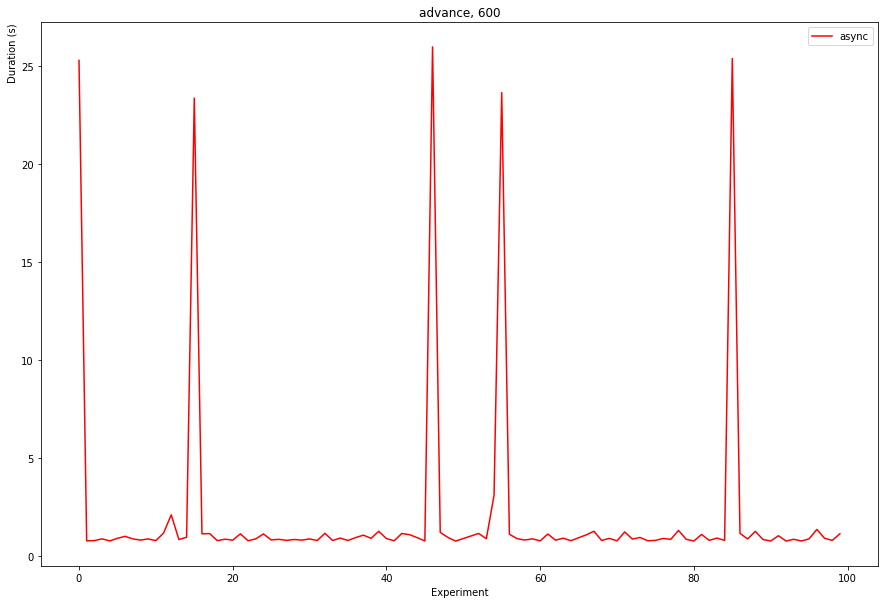

In [646]:

fn = "advance"
bs = 600
all_async = []
f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]=="20211017f151622_benchmark_e2e_s3_600_8_16_sync"]
mean_async = f_df_dataloader_s3_async["elapsed"].mean()
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
if len(f_df_dataloader_s3_async) > 0:
    print(row["run"])
all_async += list(f_df_dataloader_s3_async["elapsed"])
del f_df_dataloader_s3_async

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(all_async)), all_async, color="red",label="async")

del all_async
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Duration (s)", loc="top")
ax.set_title(f"{fn}, {bs}", loc='center')
ax.legend()